# DL-TDDFT Test

## DL-effective field and computation via auxiliary system (LSTM) analysis different time windows

#### Imports

In [1]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List


torch.set_num_threads(3)

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Data

In [94]:
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver

import qutip
from scipy.sparse.linalg import eigsh,expm

data = np.load(
    "data/dataset_h_eff/new_analysis_xxzx_model/dataset_2025-02-01_16-31.npz"
)

maxdata=500
print(data['info'])
print(data['comments'])
time=np.linspace(0,20,200)

xx-z-x model with omega=1.0, coupling=-1.0 external field with rate mean=1.5 and rate sigma=1.5 amplitude max=2.0 amplitude min=0.0 tf=20 steps=800 l variable ndata=10000 initial state option=True pbc=True
fixed Initial state ground state, with a diagonostic is False dataset. 2nd order time derivative with9-points formula


In [95]:


h = data["h"][-maxdata:]
h_eff = data["h_eff"][-maxdata:]
z=data['z'][-maxdata:]
z_auxiliary=data['z_auxiliary'][-maxdata:]
print(h.shape)

models=[]

labels=[r'$\tau J=10$ 1000 neurons',r'$\tau J=10$ 5000 neurons',r'$\tau J=5$ 5000 neurons']
#models_name=['LSTM_f2f_fixed_initial_state_tf_5_250203_dataset_10k_[1000]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock','LSTM_f2f_fixed_initial_state_tf_5_250203_dataset_10k_[3000]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock','LSTM_f2f_fixed_initial_state_tf_5_250203_dataset_10k_[5000]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock']
models_name=['LSTM_f2f_fixed_initial_state_tf_10_250203_dataset_10k_[1000]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock','LSTM_f2f_fixed_initial_state_tf_10_250204_dataset_10k_[5000]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock']
for i,name in enumerate(models_name):
    model = torch.load(
    "model_rep/"+name,
    map_location="cpu",
    )
    model.eval()
    models.append(model)
    print(model)
# Loading the model


(500, 201, 1)
LSTMTDDFT(
  (model): LSTM(1, 1000, proj_size=1, batch_first=True)
  (loss): MSELoss()
)
LSTMTDDFT(
  (model): LSTM(1, 5000, proj_size=1, batch_first=True)
  (loss): MSELoss()
)


#### Save sample for Carlos

In [14]:
h_flat=h[:5,1:,0]

data_to_save = np.column_stack((time, h_flat.T))  # Transpose h_flat to align with time

# Save to a single .txt file
filename = 'drivings.txt'
header = 'Time    driving_1    driving_2    driving_3    driving_4    driving_5'
np.savetxt(filename, data_to_save, fmt='%.6f', header=header, comments='')

print(f"Saved all signals to {filename}")

Saved all signals to drivings.txt


#### Analysis of the dataset and the TDDFT accuracy

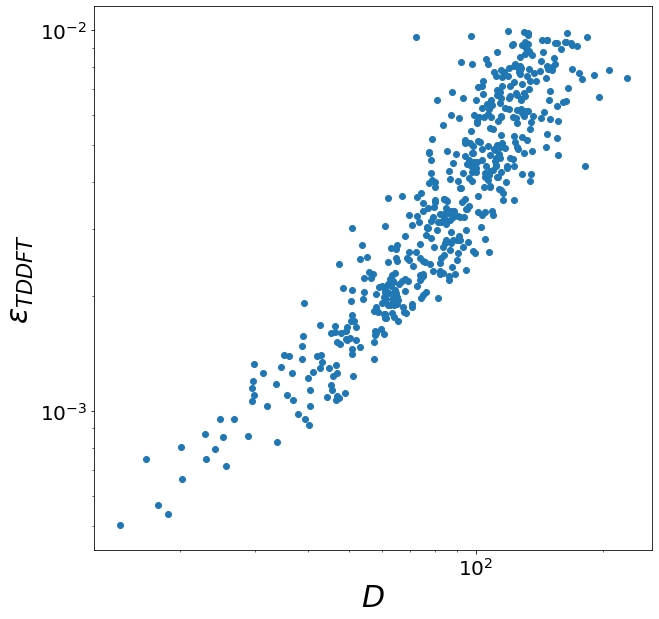

In [96]:
h_study=h[:,1:]
current_h_study=np.gradient(h_study,time,axis=1)
speed=np.average(current_h_study/(h_study+10**-5),axis=1)[:,0]

dz_average_time=np.average(np.average(np.abs(z[:,:]-z_auxiliary[:,:]),axis=-1),axis=1)

plt.figure(figsize=(10,10))
plt.scatter(speed,dz_average_time)
plt.xlabel(r'$D$',fontsize=30)
plt.ylabel(r'$\epsilon_{TDDFT}$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.loglog()
plt.show()


#### Structure of the Driving

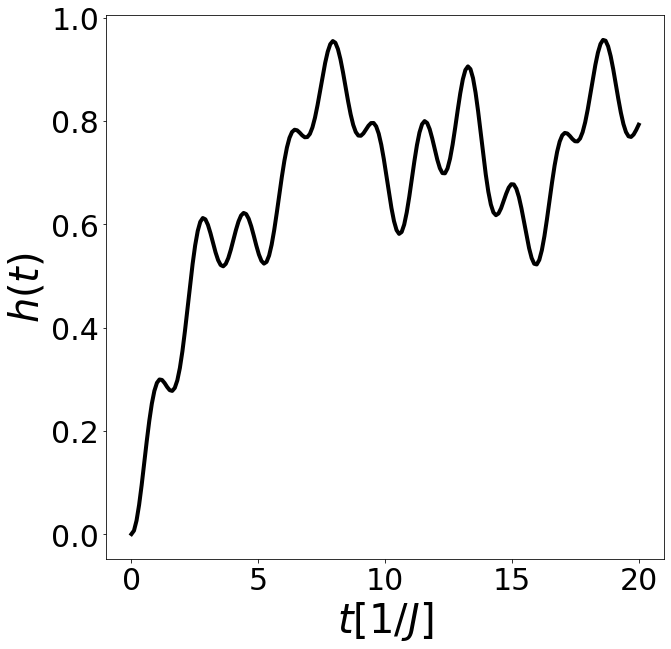

In [27]:
idx= np.random.randint(0,maxdata)

plt.figure(figsize=(10,10))
plt.plot(time,h[idx,1:,:],color='black',linewidth=4)
plt.xlabel(r'$t [1/J]$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.show()

#### $h_{eff}(t)$ from the DL mapping

In [97]:
hs_predictions=[]
for model in models:

    h_eff_prediction,_=model(torch.tensor(h))
    h_eff_prediction = h_eff_prediction.detach().numpy()
    # h_eff_prediction=np.einsum('bit->bti',h_eff_prediction)
    print(h_eff_prediction.shape)
    hs_predictions.append(h_eff_prediction)    

(500, 201, 1)
(500, 201, 1)


#### Errors

3
(200,)
(200,)


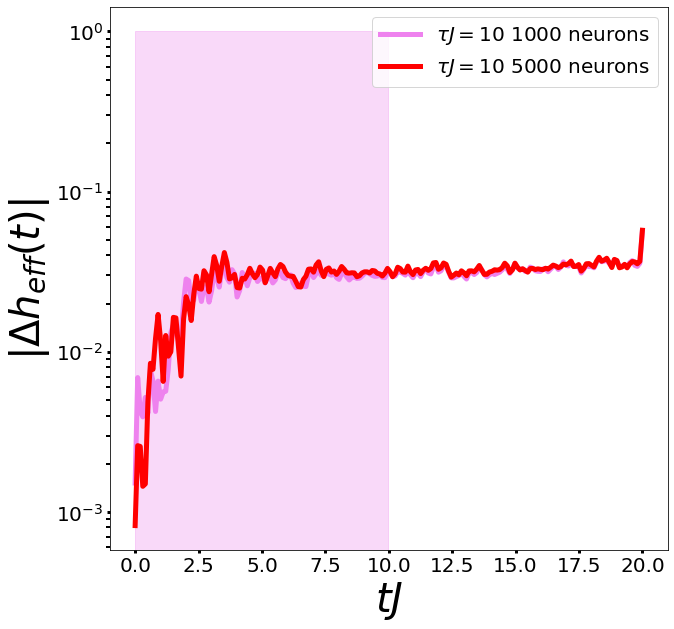

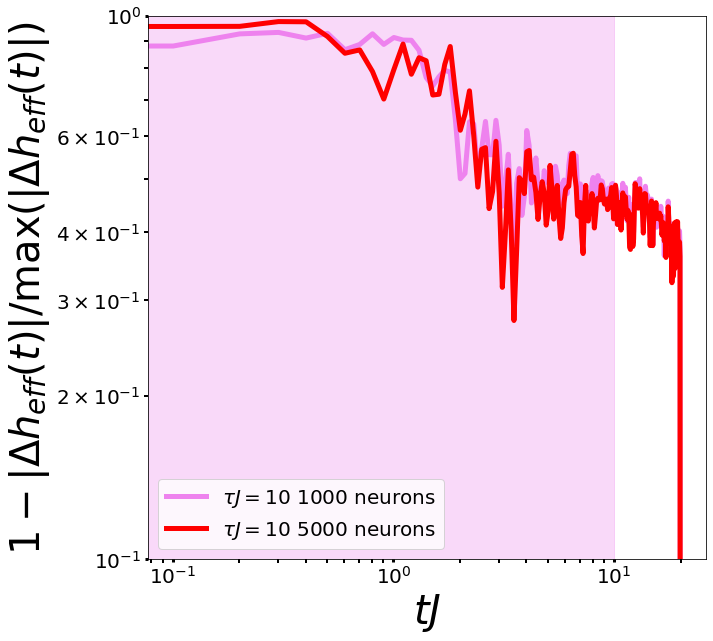

In [98]:
colors=['violet','red','blue','green']
print(len(labels))
plt.figure(figsize=(10,10))
prediction_errors=[]
for i, h_eff_prediction in enumerate(hs_predictions):
    #dh_eff=np.average(np.abs(h_eff_prediction-h_eff),axis=0)
    dh_eff=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=0)#/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)
    dh_eff_average_time=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=1)
    prediction_errors.append(dh_eff_average_time)

    print(dh_eff.shape)

    plt.plot(time,dh_eff[:],linewidth=5,label=labels[i],color=colors[i])
    
plt.tick_params(which='major',labelsize=20,length=3,width=3)
plt.tick_params(which='minor',labelsize=20,length=4,width=2)
plt.xlabel(r'$t J$',fontsize=40)
plt.fill_between(x=time[:100],y1=0,y2=1,color=colors[0],alpha=0.3)
#plt.fill_between(x=time[30:50],y1=0,y2=1,color=colors[1],alpha=0.3)
#plt.fill_between(x=time[50:100],y1=0,y2=1,color=colors[2],alpha=0.3)
#plt.fill_between(x=time[100:150],y1=0,y2=1,color=colors[3],alpha=0.3)
#plt.fill_between(x=time[150:200],y1=0,y2=1,color=colors[4],alpha=0.3)

plt.ylabel(r'$|\Delta h_{eff}(t)|$',fontsize=40)
plt.legend(fontsize=20)
plt.semilogy()

plt.show()


# plot with the normalized condition

dheffs=[]
plt.figure(figsize=(10,10))
for i, h_eff_prediction in enumerate(hs_predictions):
    #dh_eff=np.average(np.abs(h_eff_prediction-h_eff),axis=0)
    dh_eff=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=0)#/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)
    dheffs.append(dh_eff)
    max_dheff=np.max(dh_eff)
    normalized_dheff=dh_eff/max_dheff
    plt.plot(time,1-normalized_dheff+10**-3,linewidth=5,label=labels[i],color=colors[i])
    
plt.tick_params(which='major',labelsize=20,length=3,width=3)
plt.tick_params(which='minor',labelsize=20,length=4,width=2)
plt.xlabel(r'$t J$',fontsize=40)


plt.fill_between(x=time[:100],y1=0,y2=1,color=colors[0],alpha=0.3)
#plt.fill_between(x=time[30:50],y1=0,y2=1,color=colors[1],alpha=0.3)
#plt.fill_between(x=time[50:100],y1=0,y2=1,color=colors[2],alpha=0.3)
#plt.fill_between(x=time[100:150],y1=0,y2=1,color=colors[3],alpha=0.3)
#plt.fill_between(x=time[150:200],y1=0,y2=1,color=colors[4],alpha=0.3)

plt.ylim([10**-1,1])
plt.ylabel(r'$1-|\Delta h_{eff}(t)|/\mathrm{max}(|\Delta h_{eff}(t)|)$',fontsize=40)
plt.legend(fontsize=20)
plt.loglog()
plt.show()



#### Check the comparison with the exact $h_{eff}(t)$

0 8
1 8


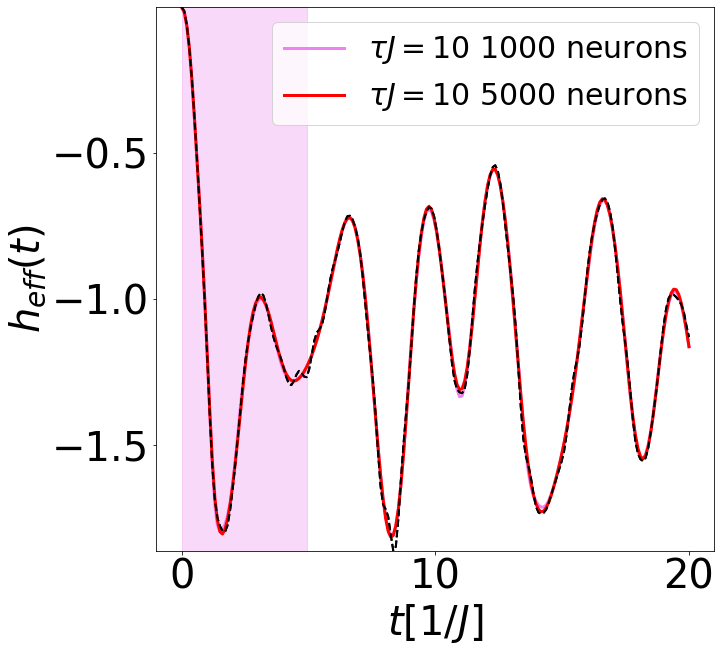

In [99]:
idx=np.random.randint(0,50)
plt.figure(figsize=(10,10))
for i,h_eff_prediction in enumerate(hs_predictions):
    print(i,idx)


    for j in range(1):

        plt.plot(time,h_eff_prediction[idx,1:,j],linewidth=3,label=labels[i],color=colors[i])
        plt.plot(time,h_eff[idx,1 :, j],color='black',linewidth=2,linestyle='--')
        plt.ylabel(r'$h_{eff}(t)$',fontsize=40)
        plt.xlabel(r'$t[1/J]$',fontsize=40)
        #plt.axvline(x=20,color='green',linestyle='--',linewidth=5)
        plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
        plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
        plt.ylim([np.min(h_eff[idx,1:,0]),np.max(h_eff[idx,1:,0])])
plt.fill_between(x=time[:50],y1=-2,y2=2,color=colors[0],alpha=0.3)
#plt.fill_between(x=time[30:50],y1=-2,y2=2,color=colors[1],alpha=0.3)
#plt.fill_between(x=time[50:100],y1=-2,y2=2,color=colors[2],alpha=0.3)
#plt.fill_between(x=time[100:150],y1=-2,y2=2,color=colors[3],alpha=0.3)
#plt.fill_between(x=time[150:200],y1=-2,y2=2,color=colors[4],alpha=0.3)
        #plt.xlim([0,40])
plt.legend(fontsize=30)
        
plt.show()

#### Scatter plot with the disorder

(500, 100)


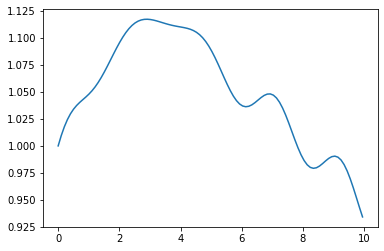

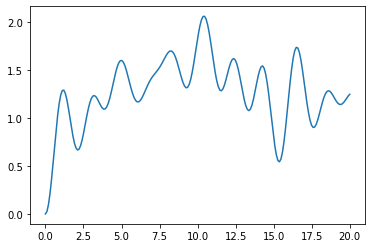

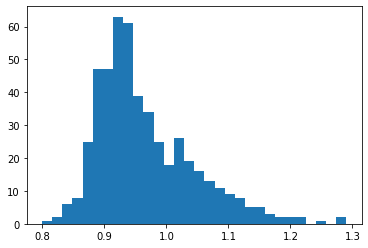

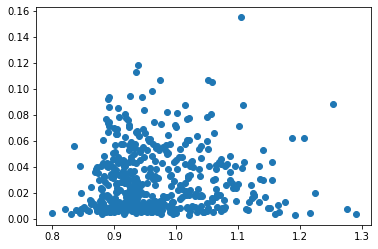

(500, 200, 1)
[ 54.40179717  88.25068177  76.40537066 115.28423836  63.07387518
 130.21624027 124.33903329 135.80166845  87.05679194  59.77608487
  75.79278252 130.09491186 106.43747952  80.07425431  34.60408146
  78.20541107 107.23132865  29.86279082  68.07930904 101.0332564
 147.09114463 120.57511258 148.75298847  98.31648104 100.11190348
  31.39783526 177.6387262   49.54393368  97.40776409  63.70184147
  47.38533384  68.31896321 142.92724779  95.62880405 116.90771767
 114.78005178 126.49175831 159.12442561  57.50664551 115.54931963
  29.52842939  75.15850553  92.28147658  90.17638992 119.86058512
  94.38182809 138.98134436  64.39789662  42.02350811  84.25832367
 135.48237607  88.47252489 105.27049117 108.02916926  79.99441828
  55.88494693  96.88119126  50.55194184  44.45791845  72.61568426
  90.58965381 168.689619    78.55422124 206.59724095  74.85445999
  43.08034536  62.92441301 118.78054633  61.82002019  45.64414698
  84.76514348 108.46052034 111.0728139  182.82881288 146.753276

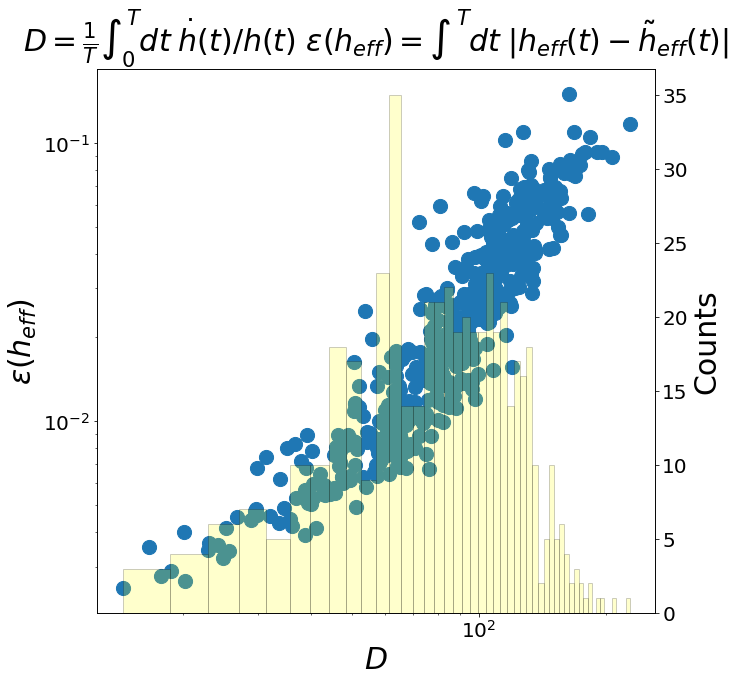

[ 54.40179717  88.25068177  76.40537066 115.28423836  63.07387518
 130.21624027 124.33903329 135.80166845  87.05679194  59.77608487
  75.79278252 130.09491186 106.43747952  80.07425431  34.60408146
  78.20541107 107.23132865  29.86279082  68.07930904 101.0332564
 147.09114463 120.57511258 148.75298847  98.31648104 100.11190348
  31.39783526 177.6387262   49.54393368  97.40776409  63.70184147
  47.38533384  68.31896321 142.92724779  95.62880405 116.90771767
 114.78005178 126.49175831 159.12442561  57.50664551 115.54931963
  29.52842939  75.15850553  92.28147658  90.17638992 119.86058512
  94.38182809 138.98134436  64.39789662  42.02350811  84.25832367
 135.48237607  88.47252489 105.27049117 108.02916926  79.99441828
  55.88494693  96.88119126  50.55194184  44.45791845  72.61568426
  90.58965381 168.689619    78.55422124 206.59724095  74.85445999
  43.08034536  62.92441301 118.78054633  61.82002019  45.64414698
  84.76514348 108.46052034 111.0728139  182.82881288 146.75327658
  67.648580

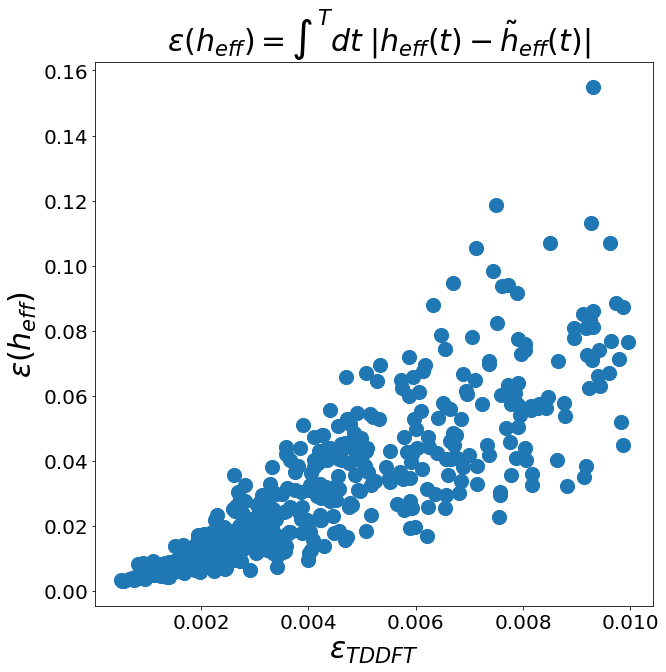

In [35]:

# correlator

idx=np.random.randint(0,50)
h_study=h[:,1:,:]
t=np.arange(time.shape[0]//2)
tau=np.arange(time.shape[0]//2)

matrix_correlator=np.zeros((h_study.shape[0],time.shape[0]//2,time.shape[0]//2))

matrix_correlator=h_study[:,t[:,None],0]*h_study[:,t[:,None]+tau[None,:],0]

correlator=np.average(matrix_correlator,axis=1)

normalized_correlator=correlator/correlator[:,0,None]
print(normalized_correlator.shape)
plt.plot(time[:time.shape[0]//2],normalized_correlator[idx])
plt.show()

plt.plot(time[:500],h_study[idx,:500,0])
plt.show()

average_normalized_correlator=np.average(normalized_correlator,axis=-1)

plt.hist(average_normalized_correlator,bins=30)
plt.show()

plt.scatter(average_normalized_correlator,prediction_errors[-1])
plt.show()

# standard deviation

zero_mean_h_study=h_study-np.average(h_study,axis=1)[:,None,:]
std_h_study=np.std(zero_mean_h_study,axis=1)[:,0]


# speed
print(h_study.shape)
current_h_study=np.gradient(h_study,time,axis=1)
speed=np.average(current_h_study/(h_study+10**-5),axis=1)[:,0]




print(speed)
fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
ax.scatter(speed,prediction_errors[0],s=200)
ax.set_xlabel(r'$D$',fontsize=30)
ax.set_ylabel(r'$\epsilon(h_{eff})$',fontsize=30)
plt.title(r'$D=\frac{1}{T}\int^{T}_0 d t \; \dot{h}(t)/h(t)$ $\epsilon(h_{eff})=\int^T d t \; |h_{eff}(t)-\tilde{h}_{eff}(t)|$',fontsize=30)
ax.tick_params(which='major',labelsize=20)
ax_twin.tick_params(which='major',labelsize=20)
ax_twin.hist(speed,bins=50,edgecolor='black', alpha=0.2,color='yellow')
ax_twin.set_ylabel('Counts',fontsize=30)
ax.loglog()
plt.show()


print(speed)
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(dz_average_time,prediction_errors[1],s=200)
ax.set_xlabel(r'$\epsilon_{TDDFT}$',fontsize=30)
ax.set_ylabel(r'$\epsilon(h_{eff})$',fontsize=30)
plt.title(r' $\epsilon(h_{eff})=\int^T d t \; |h_{eff}(t)-\tilde{h}_{eff}(t)|$',fontsize=30)
ax.tick_params(which='major',labelsize=20)
plt.show()




#### More effective field samples

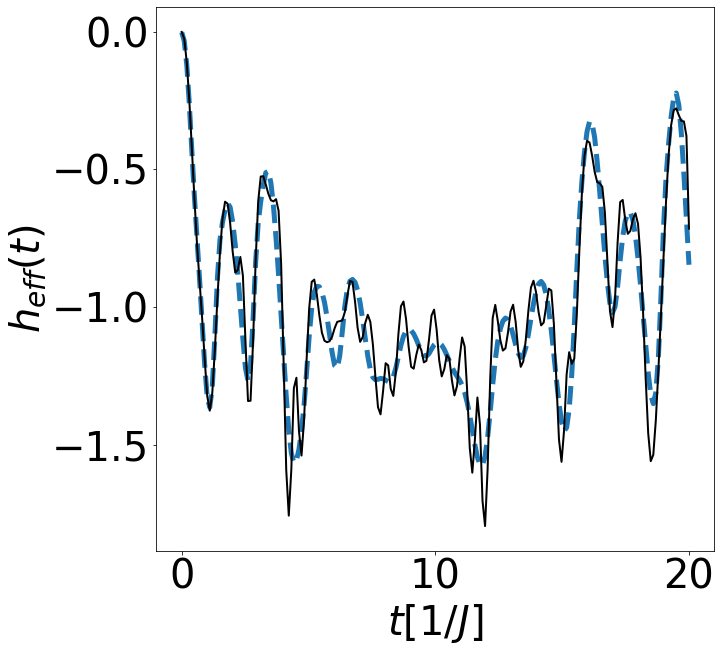

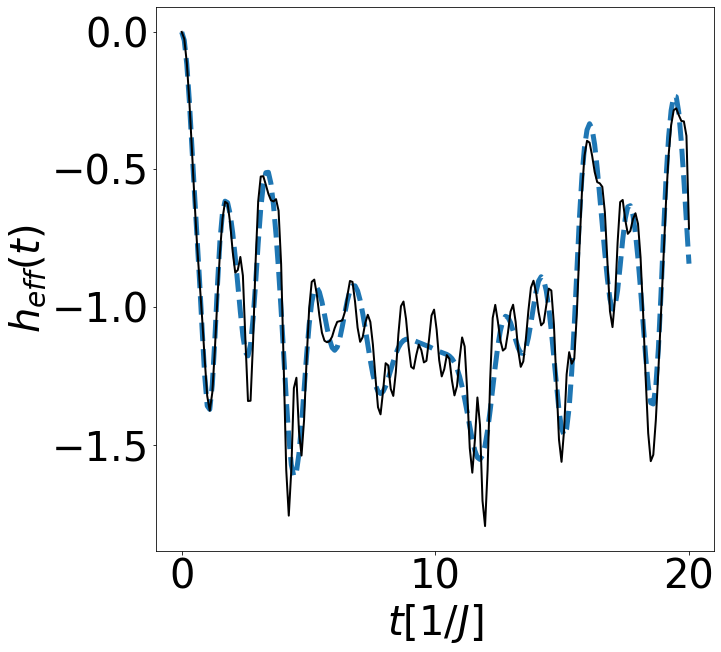

In [101]:
idx=np.random.randint(0,maxdata)


# for idx in range(h_eff.shape[-1]):
for i,h_eff_prediction in enumerate(hs_predictions):
    plt.figure(figsize=(10,10))
    plt.plot(time,h_eff_prediction[idx,1:,:2],linestyle='--',linewidth=5,label=labels[i])
    plt.plot(time,h_eff[idx,1 :, :2],color='black',linewidth=2)
    plt.ylabel(r'$h_{eff}(t)$',fontsize=40)
    plt.xlabel(r'$t[1/J]$',fontsize=40)
    #plt.axvline(x=20,color='green',linestyle='--',linewidth=5)
    #plt.legend(fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
    plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
    #plt.fill_between(time[:200], -4.6,-2.1, color='gold', alpha=0.3)
    #plt.ylim([-4.6,-2.1])
    #plt.xlim([0,40])
    plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [33]:
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver

import qutip
import numpy as np
from scipy.integrate import solve_ivp

class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [ ]:
from scipy.interpolate import interp1d
# build up the operators
x_op=np.array([[0.,1.],[1.,0]],dtype=np.complex128)
z_op=np.array([[1.,0.],[0.,-1.]],dtype=np.complex128)

# maybe there is a problem with the time step



maxdata=100

nsteps=600

old_steps=200

tf=20.
l=8
j=-1. 
omega=1.

old_time=np.linspace(0,tf,old_steps)
time = np.linspace(0.0, tf,nsteps)
dt=time[1]-time[0]



p=np.random.randint(0,maxdata)

zs_prediction=[] #list for the predictions
for q,h_eff_prediction in enumerate(hs_predictions):
    print(q)
    #slot for the prediction
    z_prediction=np.zeros((maxdata,old_steps,l))
    
    # initialize the effective field with the interpolation
    # to more dense grids
    print(h_eff_prediction.shape)
    print(h_eff.shape)
    old_h_eff=h_eff_prediction[:,1:].copy()
    #old_h_eff=h_eff[:,1:].copy()
    f=interp1d(old_time,old_h_eff,axis=1)
    h_eff_operation=f(time)
    
    print(h_eff_operation.shape)

    for a in trange(maxdata):
        psi=np.zeros((2,l))
        psi[0] = np.sqrt((1 + z[a,0]) / 2)
        psi[1] = np.sqrt((1 - z[a,0]) / 2)
        h_eff_sample=h_eff_operation[a]
        print(h_eff_sample.shape)
        z_reconstruction=np.zeros((nsteps,l))
        for i in range(nsteps):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi),x_op,psi)
            #pbc
            nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            
            #obc
            # shift_plus=np.zeros(l)
            # shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
            
            
            # shift_minus=np.zeros(l)
            # shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
            # nonlinear_term=j*(shift_plus+shift_minus)+omega
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff_sample[i,0,None,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi=np.einsum('lab,bl->al',exp_h_t,psi)
            psi=psi/np.linalg.norm(psi,axis=0)
            
            z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
            
        z_prediction[a]=np.array([np.interp(old_time, time, z_reconstruction[:, i]) for i in range(z_reconstruction.shape[1])]).T
    
    zs_prediction.append(z_prediction)
        

 PBC

26


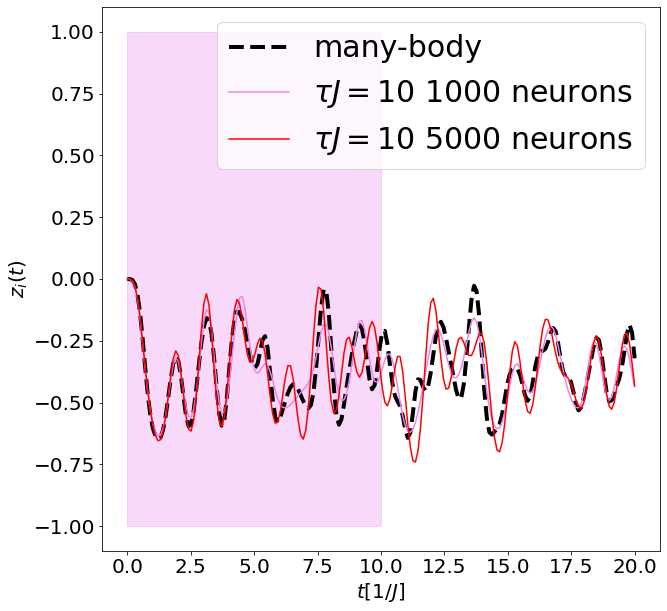

In [114]:
idx=np.random.randint(0,maxdata)
fig,ax=plt.subplots(figsize=(10,10))
r=0
idx=np.random.randint(0,maxdata)
print(idx)
ax.plot(old_time,z[idx,:,r],color='black',label='many-body',linestyle='--',linewidth=4)
ax.plot(old_time,zs_prediction[0][idx,:,r],color=colors[0],label=labels[0])
ax.plot(old_time,zs_prediction[1][idx,:,r],color=colors[1],label=labels[1])
#ax.plot(old_time,zs_prediction[2][idx,:,r],color=colors[2],label=labels[2])
if i==0 and j==0:
    ax.legend(fontsize=30)
ax.set_ylabel(r'$z_i(t)$',fontsize=20)
ax.set_xlabel(r'$t[1/J]$',fontsize=20)
ax.tick_params(which='major',labelsize=20)
plt.fill_between(x=time[:300],y1=-1,y2=1,color=colors[0],alpha=0.3)
#plt.fill_between(x=time[300:500],y1=-1,y2=1,color=colors[1],alpha=0.3)
#plt.fill_between(x=time[500:1000],y1=-1,y2=1,color=colors[2],alpha=0.3)
#plt.fill_between(x=time[1000:1500],y1=-1,y2=1,color=colors[3],alpha=0.3)
#plt.fill_between(x=time[1500:2000],y1=-1,y2=1,color=colors[4],alpha=0.3)
plt.legend(fontsize=30)

plt.show()

(500, 200, 1)
(100, 200, 8)
2
0
(200,)
1
(200,)


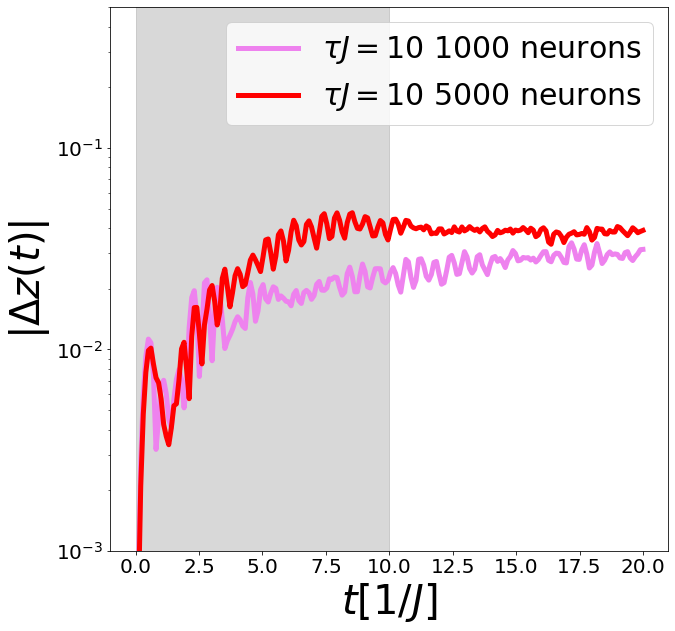

In [107]:
print(z.shape)
print(z_prediction.shape)
print(len(zs_prediction))
plt.figure(figsize=(10,10))
dzs=[]
for i in range(2):
    print(i)
    dz=np.average(np.average(np.abs(zs_prediction[i]-z[:maxdata,:,:]),axis=-1),axis=0)
    dzs.append(dz)
    print(dz.shape)
    
    q=0
    plt.plot(old_time,dz,linewidth=5,color=colors[i],label=labels[i])
plt.fill_between(x=time[:300],y1=0,y2=1,color='grey',alpha=0.3)


plt.semilogy()
plt.legend(fontsize=30)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z (t)|$',fontsize=40)
plt.ylim([10**-3,0.5])
plt.tick_params(which='major',labelsize=20)
plt.show()

#### Correlation between the $h_{eff}(t)$ error and $z(t)$

R^2= 0.7675827839363549 slope= 1.277901031095712


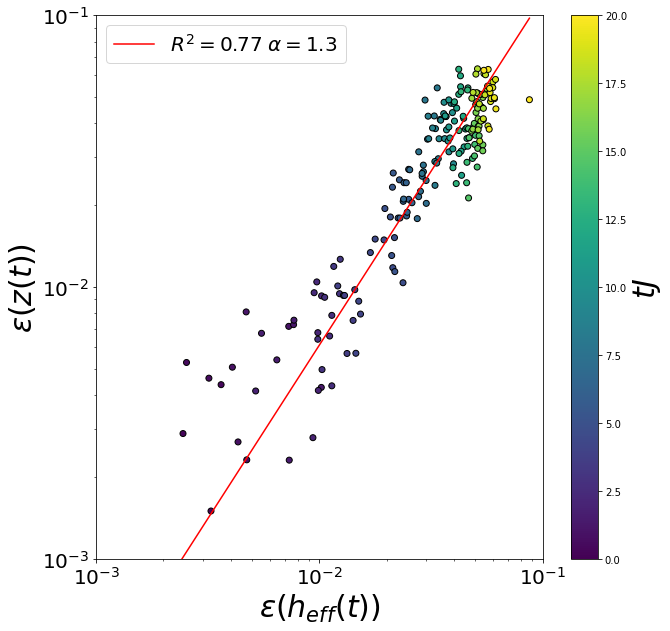

In [71]:
# fit using chatgpt
x=np.log(dheffs[-3])
y=np.log(dzs[-3])

coefficients = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
slope, intercept = coefficients
y_pred = np.polyval(coefficients, x)  # Predicted y values

# Calculate R^2
ss_res = np.sum((y - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)



print('R^2=',r_squared,'slope=',slope)
plt.figure(figsize=(10,10))
time_plot=np.linspace(0,20,200)


plt.scatter(dheffs[-3],dzs[-3],c=time_plot, cmap='viridis', edgecolor='k')
plt.plot(dheffs[-3],np.exp(intercept)*dheffs[-3]**slope,color='red',label=r'$R^2=$'+f'{r_squared:.2f}'+r'$\; \alpha=$'+f'{slope:.2}')
#plt.scatter(dheffs[-3][time_plot>10],dzs[-3][time_plot>10],color='red')
clbar=plt.colorbar()
clbar.set_label(r'$tJ$',fontsize=30)
plt.xlabel(r'$\epsilon(h_{eff}(t))$',fontsize=30)
plt.ylabel(r'$\epsilon(z(t))$',fontsize=30)
plt.tick_params(labelsize=20,)
plt.ylim(10**-3,0.1)
plt.xlim(10**-3,0.1)
plt.loglog()
plt.legend(fontsize=20)
plt.show()





#### Test a different field

#### Compute the Hamiltonian

8
8
8
8
8
8
8
8


  0%|          | 0/1 [00:00<?, ?it/s]

(600, 8)


FileNotFoundError: [Errno 2] No such file or directory: 'images/quench_driving_gamma_1.png'

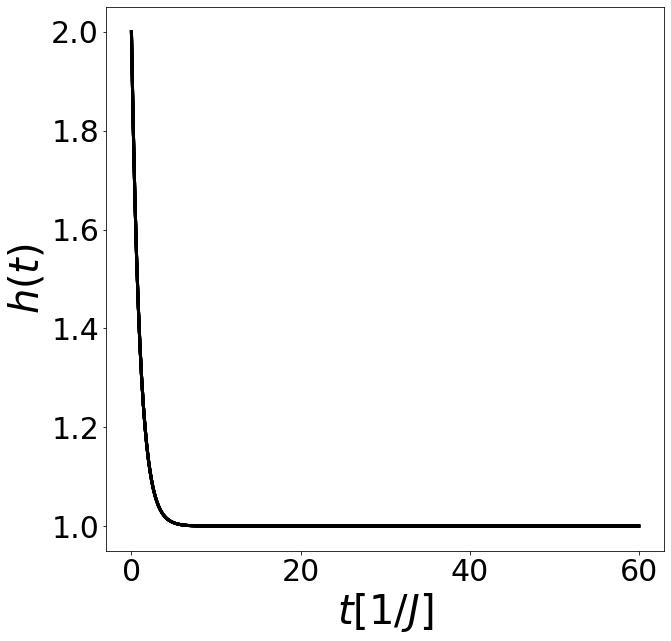

In [160]:
class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

nbatch = 1

l = 8
# rates = [0.1, 0.5, 0.8, 1.0]

# j coupling
j = 1
# omega auxiliary field
maxdata=1
omega = 1
maxdata=1
rate_max=1.
rate_min=0.1

amplitude_max=1
amplitude_min=0.1

steps = 600
tf = 60.0
time = np.linspace(0.0, tf, steps)
gamma=1

ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=False,
    coupling_values=[j],
    size=l,
)

hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

obs: List[qutip.Qobj] = []
current_obs: List[qutip.Qobj] = []

for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    #pbc
    # current = SpinOperator(
    #     index=[("x", (i - 1) % l, "y", i), ("y", i, "x", (i + 1) % l)],
    #     coupling=[2 * j, 2 * j],
    #     size=l,
    # )
    #obc
    print(l)
    # if i-1 >=0 and i+1<=l-1:
    #     current = SpinOperator(
    #         index=[("x", (i - 1) , "y", i), ("y", i, "x", (i + 1) )],
    #         coupling=[2 * j, 2 * j],
    #         size=l,
    #     )

    obs.append(z_op.qutip_op)
    # current_obs.append(current.qutip_op)

heffs=np.zeros((maxdata,steps,l))
hs=np.zeros_like(heffs)
z=np.zeros((maxdata,steps,l))    


for a in trange(maxdata):
    final_value=1
    initial_value=2
    hf=final_value*np.ones((time.shape[0], l))
    hi=initial_value*np.ones((time.shape[0], l))

    # rate = np.random.uniform(0.3, 1.0)

    rate_cutoff = 15
    rate=np.random.uniform(rate_min,rate_max,size=rate_cutoff)
    delta = np.random.uniform(amplitude_min,amplitude_max,size=(rate_cutoff))

    h = (
        delta[:, None, None]
        * np.sin(time[None, :, None] * rate[:, None, None])
        + hi
    )

    #h=np.exp(-time*gamma)[:,None]*hi[None,:]+(1-np.exp(-time*gamma)[:,None])*hf[None,:]
    #h=h[0]

    h = np.average(h, axis=0)
    print(h.shape)
    h=hi*np.exp(-time*gamma)[:,None]+(1-np.exp(-time*gamma)[:,None])*hf[None,:]

    h=h[0]
    
    plt.figure(figsize=(10,10))
    plt.plot(time,h,color='black',linewidth=3)
    plt.xlabel(r'$t[1/J]$',fontsize=40)
    plt.ylabel(r'$h(t)$',fontsize=40)
    plt.tick_params(which='major',labelsize=30)
    plt.savefig(f'images/quench_driving_gamma_{gamma:.0f}')
    plt.show()
    print(h.shape)
    hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

    eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
        eigvals=1
    )
    psi0 = psi0[
        0
    ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))

    print("real ground state energy=", eng[0])

    hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

    for i in range(l):
        drive_z = Driving(
            h=h,
            dt=time[1] - time[0],
            idx=i,
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution and

    output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs)

    current_exp = np.zeros((steps, l))
    z_exp = np.zeros_like(current_exp)

    for r in range(l):
        z_exp[:, r] = output.expect[r]
        

    # Current derivative
    current_exp=np.gradient(z_exp, time, axis=0)
    current_derivative = np.gradient(current_exp, time, axis=0)

    # compute the effective field
    x_sp = np.sqrt(1 - z_exp**2) * np.cos(
        np.arcsin(-1 * (current_exp) / (2 * np.sqrt(1 - z_exp**2)))
    )


    current_derivative = np.gradient(current_exp, time, axis=0)
    #plt.plot(current_derivative)
    #pbc
    # nonlinear_term=j*(np.roll(x_sp,shift=1,axis=-1)+np.roll(x_sp,shift=-1,axis=-1))
    # plt.plot(nonlinear_term)
    # part_1=0.25*current_derivative/(nonlinear_term+omega)
    # part_2=(nonlinear_term+omega)*z_exp
    # h_eff = (part_1 + part_2) / (x_sp + 10**-4)

    #obc
    shift_plus=np.zeros((time.shape[0],l))
    shift_plus[:,1:]=x_sp[:,1:] #np.roll(x_sp,shift=1,axis=-1)
    shift_minus=np.zeros((time.shape[0],l))
    shift_minus[:,:-1]=x_sp[:,:-1] #np.roll(x_sp,shift=-1,axis=-1)
    nonlinear_term=j*(shift_plus+shift_minus)
    part_1=0.25*current_derivative/(nonlinear_term+omega)
    part_2=(nonlinear_term+omega)*z_exp
    h_eff = (part_1 + part_2) / (x_sp + 10**-20)
    
    heffs[a]=h_eff
    hs[a]=h
    z[a]=z_exp


In [ ]:
print(h.shape)
print(h_eff.shape)
print(z.shape,hs.shape)
input=np.append(z[:,0].reshape(-1,1,l),hs,axis=1)


heff_prediction,_=model(torch.from_numpy(input))
heff_prediction=heff_prediction.detach().numpy()
print(heff_prediction.shape)
plt.plot(time,heff_prediction[0,1:],color='red',linestyle='--')
plt.plot(time,heffs[0,:],color='black',linestyle='-')
plt.show()


p=np.random.randint(0,maxdata)

plt.figure(figsize=(10,10))
plt.plot(time,hs[p],color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,heff_prediction[p,1:],color='red',linestyle='--',linewidth=4,)
plt.plot(time,heffs[p],color='black',linewidth=4,)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h_{eff,i}(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.title('red line prediction, black line exact',fontsize=30)
plt.savefig(f'images/periodic_effective_field_gamma_{gamma:.0f}')
plt.show()


dheff=np.average(np.abs(heff_prediction[:,1:]-heffs),axis=(0,-1))

plt.figure(figsize=(10,10))
plt.plot(time,dheff,color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta h_{eff}(t)|$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.show()


In [ ]:
from scipy.interpolate import interp1d
# build up the operators
x_op=np.array([[0.,1.],[1.,0]],dtype=np.complex128)
z_op=np.array([[1.,0.],[0.,-1.]],dtype=np.complex128)


nsteps=600
tf=60.
l=8
j=1. 
omega=1.
time = np.linspace(0.0, tf,nsteps)
dt=time[1]-time[0]

p=np.random.randint(0,maxdata)


z_prediction=np.zeros((maxdata,nsteps,l))

print(hs_predictions[0][p,:2])
for a in trange(maxdata):
    psi=np.zeros((2,l))
    psi[0] = np.sqrt((1 + z[a,0]) / 2)
    psi[1] = np.sqrt((1 - z[a,0]) / 2)
    h_eff_sample=heff_prediction[a,1:]
    z_reconstruction=np.zeros((nsteps,l))
    for i in range(nsteps):
        x_ave=np.einsum('al,ab,bl->l',np.conj(psi),x_op,psi)
        #pbc
        #nonlinear_term=j*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
        
        #obc
        shift_plus=np.zeros(l)
        shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
        shift_minus=np.zeros(l)
        shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
        nonlinear_term=j*(shift_plus+shift_minus)+omega
        hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff_sample[i,:,None,None]*z_op[None,:,:]
        exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
        for r in range(l):
            exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
        #print(exp_h_t)    
        psi=np.einsum('lab,bl->al',exp_h_t,psi)
        psi=psi/np.linalg.norm(psi,axis=0)
        
        z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
    z_prediction[a]=z_reconstruction

In [ ]:
fig,ax=plt.subplots(4,2,figsize=(40,60))
for i in range(4):
    for j in range(2):
        r=(i)+4*(j)
        ax[i,j].plot(time,z_prediction[p,:,r],color='red',linestyle='--',linewidth=5)
        ax[i,j].plot(time,z[p,:,r],color='black',linestyle='-',linewidth=5)
        ax[i,j].tick_params(which='major',labelsize=30)
        ax[i,j].set_xlabel(r'$t[1/J]$',fontsize=40)
        ax[i,j].set_ylabel(r'$z_i(t)$',fontsize=40)
        ax[i,j].set_title(f'i={r}',fontsize=40)
plt.show()

dz=np.average(np.abs(z_prediction-z),axis=(0,-1))
plt.figure(figsize=(10,10))
plt.plot(time,dz,color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z(t)|$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.savefig(f'images/magnetization_results_inverse_quench_gamma_{gamma:.0f}')
plt.show()


In [ ]:
l =1
steps = 400
tf = 40.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)

zs_prediction=[]
for j in range(10):

    for idx in range(l):
        psi0 = np.zeros(2)
        psi0[0] = np.sqrt((1 + zs[j, 0]) / 2)
        psi0[1] = np.sqrt((1 - zs[j, 0]) / 2)
        
        if idx==0:
            psi=psi0
        else:
            psi=np.kron(psi,psi0)
            
    psi0 = qutip.Qobj(
        psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
    )



    # Measure observable
    obs:List=[]
    for i in range(l):
        obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)


    # build up the time dependent object for the qutip evolution
    hamiltonian = [ham0.qutip_op]
    for i in range(l):
        drive_z = Driving(
            h=
                h_eff_prediction[j,1:]
            ,
            idx=i,
            dt=time[1] - time[0],
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution
    output = qutip.sesolve(
        hamiltonian,
        psi0,
        time,
        e_ops=obs
    )

    z_prediction=np.zeros((time.shape[0],l))
    for r in range(l):
        z_prediction[:, r] = output.expect[r]
    
    zs_prediction.append(z_prediction)

zs_prediction=np.asarray(zs_prediction)
    

In [ ]:
print(zs.shape,zs_prediction.shape)
dz=np.average(np.abs(zs_prediction[:,:,0]-zs[:,:]),axis=0)

plt.plot(time,dz)
plt.xlabel(r'$t [1/J]$',fontsize=30)
plt.ylabel(r'$|\Delta z (t)|$',fontsize=40)

plt.show()


for i in range(10):
    
    plt.plot(time,zs[i])
    plt.plot(time,zs_prediction[i])
    plt.show()

In [ ]:
plt.plot(time,z_exp)
plt.plot(time,z_prediction)
plt.show()

## DL-effective field and computation via auxiliary system (LSTM) analysis different time windows (longer times)

#### Imports

In [72]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import field2field_mapping

torch.set_num_threads(3)

#### Data

In [77]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip
from scipy.sparse.linalg import eigsh,expm

data = np.load(
    "data/dataset_h_eff/new_analysis_xxzx_model/dataset_2024-12-18_17-05.npz"
)

maxdata=500
print(data['info'])
print(data['comments'])
time=np.linspace(0,60,600)

xx-z-x model with omega=1.0, coupling=-1.0 external field with rate mean=1.5 and rate sigma=1.5 amplitude max=2.0 amplitude min=0.0 tf=60 steps=6000 l variable ndata=1000 initial state option=True pbc=True
fixed Initial state not ground state, test set


In [78]:


h = data["h"][-maxdata:]
h_eff = data["h_eff"][-maxdata:]
z=data['z'][-maxdata:]
z_auxiliary=data['z_auxiliary'][-maxdata:]
print(h.shape)

models=[]

labels=[r'$\tau J=3$',r'$\tau J=5$',r'$\tau J=10$',r'$\tau J=15$',r'$\tau J=20$']
models_name=['LSTM_field2field_xxzx_nonlinear_auxiliary_field_fixed_initial_state_time_steps_30_tf_3_241219_dataset_5k_[500, 500, 500, 500]_hc_[5, 1]_ks_0_ps_4_nconv_1_nblock','LSTM_field2field_xxzx_nonlinear_auxiliary_field_fixed_initial_state_time_steps_50_tf_5_241219_dataset_5k_[500, 500, 500, 500]_hc_[5, 1]_ks_0_ps_4_nconv_1_nblock','LSTM_field2field_xxzx_nonlinear_auxiliary_field_fixed_initial_state_time_steps_100_tf_10_241211_dataset_5k_[500, 500, 500, 500]_hc_[5, 1]_ks_0_ps_4_nconv_1_nblock','LSTM_field2field_xxzx_nonlinear_auxiliary_field_fixed_initial_state_time_steps_150_tf_15_241213_dataset_5k_[500, 500, 500, 500]_hc_[5, 1]_ks_0_ps_4_nconv_1_nblock','LSTM_field2field_xxzx_nonlinear_auxiliary_field_fixed_initial_state_time_steps_200_tf_20_241211_dataset_5k_[500, 500, 500, 500]_hc_[5, 1]_ks_0_ps_4_nconv_1_nblock']
#models_name=['LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240625_dataset_20k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240628_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_200_tf_40_240629_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock']
for i,name in enumerate(models_name):
    model = torch.load(
    "model_rep/new_analysis_lstm_field2field/"+name,
    map_location="cpu",
    )
    model.eval()
    models.append(model)
    print(model)
# Loading the model


(500, 601, 1)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)


#### Save sample for Carlos

In [79]:
h_flat=h[:5,1:,0]

data_to_save = np.column_stack((time, h_flat.T))  # Transpose h_flat to align with time

# Save to a single .txt file
filename = 'drivings.txt'
header = 'Time    driving_1    driving_2    driving_3    driving_4    driving_5'
np.savetxt(filename, data_to_save, fmt='%.6f', header=header, comments='')

print(f"Saved all signals to {filename}")

Saved all signals to drivings.txt


#### Analysis of the dataset and the TDDFT accuracy

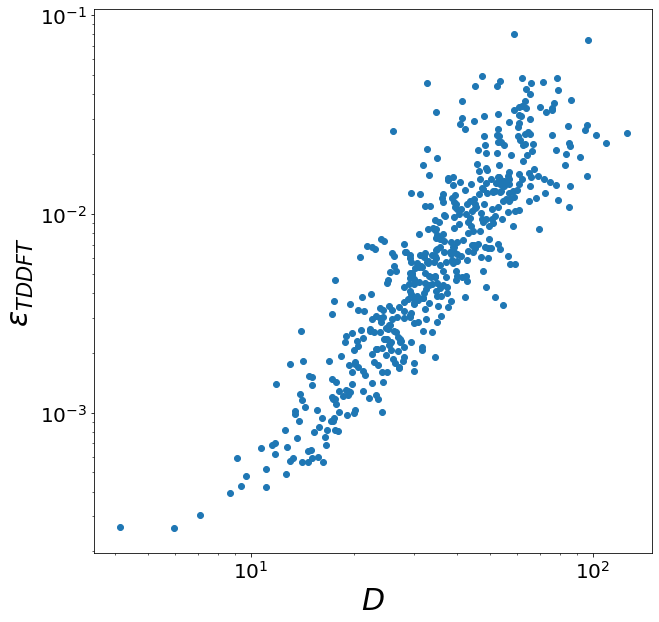

In [80]:
h_study=h[:,1:]
current_h_study=np.gradient(h_study,time,axis=1)
speed=np.average(current_h_study/(h_study+10**-5),axis=1)[:,0]

dz_average_time=np.average(np.average(np.abs(z[:,:]-z_auxiliary[:,:]),axis=-1),axis=1)

plt.figure(figsize=(10,10))
plt.scatter(speed,dz_average_time)
plt.xlabel(r'$D$',fontsize=30)
plt.ylabel(r'$\epsilon_{TDDFT}$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.loglog()
plt.show()


#### Structure of the Driving

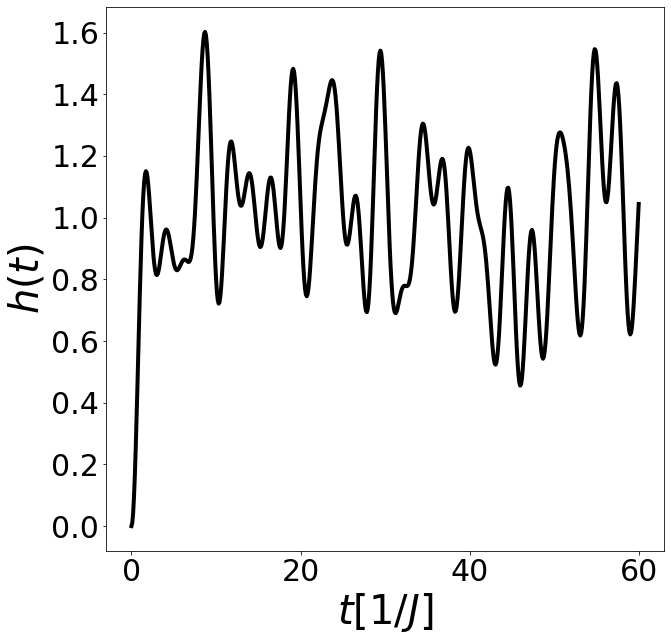

In [81]:
idx= np.random.randint(0,maxdata)

plt.figure(figsize=(10,10))
plt.plot(time,h[idx,1:,:],color='black',linewidth=4)
plt.xlabel(r'$t [1/J]$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.savefig('images/sample_driving_obc_training_dataset')
plt.show()

#### $h_{eff}(t)$ from the DL mapping

In [82]:
hs_predictions=[]
for model in models:

    h_eff_prediction,_=model(torch.tensor(h))
    h_eff_prediction = h_eff_prediction.detach().numpy()
    # h_eff_prediction=np.einsum('bit->bti',h_eff_prediction)
    print(h_eff_prediction.shape)
    hs_predictions.append(h_eff_prediction)    

(500, 601, 1)
(500, 601, 1)
(500, 601, 1)
(500, 601, 1)
(500, 601, 1)


#### Errors

5
(600,)
(600,)
(600,)
(600,)
(600,)


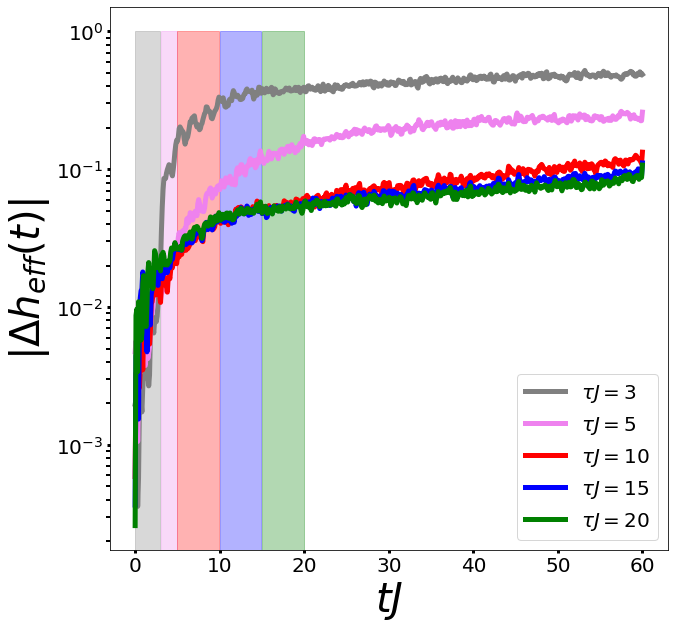

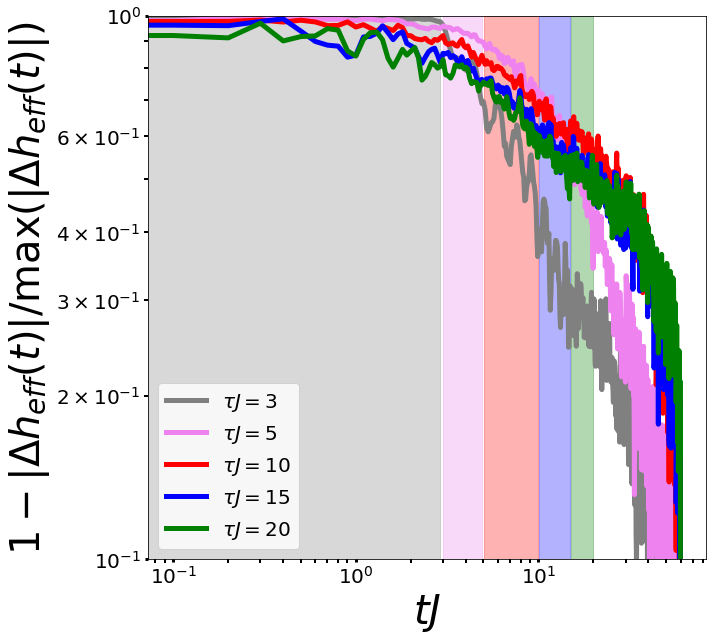

In [83]:
colors=['grey','violet','red','blue','green']
print(len(labels))
plt.figure(figsize=(10,10))
prediction_errors=[]
for i, h_eff_prediction in enumerate(hs_predictions):
    #dh_eff=np.average(np.abs(h_eff_prediction-h_eff),axis=0)
    dh_eff=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=0)#/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)
    dh_eff_average_time=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=1)
    prediction_errors.append(dh_eff_average_time)

    print(dh_eff.shape)

    plt.plot(time,dh_eff[:],linewidth=5,label=labels[i],color=colors[i])
    
plt.tick_params(which='major',labelsize=20,length=3,width=3)
plt.tick_params(which='minor',labelsize=20,length=4,width=2)
plt.xlabel(r'$t J$',fontsize=40)
plt.fill_between(x=time[:30],y1=0,y2=1,color=colors[0],alpha=0.3)
plt.fill_between(x=time[30:50],y1=0,y2=1,color=colors[1],alpha=0.3)
plt.fill_between(x=time[50:100],y1=0,y2=1,color=colors[2],alpha=0.3)
plt.fill_between(x=time[100:150],y1=0,y2=1,color=colors[3],alpha=0.3)
plt.fill_between(x=time[150:200],y1=0,y2=1,color=colors[4],alpha=0.3)

plt.ylabel(r'$|\Delta h_{eff}(t)|$',fontsize=40)
plt.legend(fontsize=20)
plt.semilogy()
plt.savefig('images/effective_field_error_obc')
plt.show()


# plot with the normalized condition

dheffs=[]
plt.figure(figsize=(10,10))
for i, h_eff_prediction in enumerate(hs_predictions):
    #dh_eff=np.average(np.abs(h_eff_prediction-h_eff),axis=0)
    dh_eff=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=0)#/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)
    dheffs.append(dh_eff)
    max_dheff=np.max(dh_eff)
    normalized_dheff=dh_eff/max_dheff
    plt.plot(time,1-normalized_dheff+10**-3,linewidth=5,label=labels[i],color=colors[i])
    
plt.tick_params(which='major',labelsize=20,length=3,width=3)
plt.tick_params(which='minor',labelsize=20,length=4,width=2)
plt.xlabel(r'$t J$',fontsize=40)


plt.fill_between(x=time[:30],y1=0,y2=1,color=colors[0],alpha=0.3)
plt.fill_between(x=time[30:50],y1=0,y2=1,color=colors[1],alpha=0.3)
plt.fill_between(x=time[50:100],y1=0,y2=1,color=colors[2],alpha=0.3)
plt.fill_between(x=time[100:150],y1=0,y2=1,color=colors[3],alpha=0.3)
plt.fill_between(x=time[150:200],y1=0,y2=1,color=colors[4],alpha=0.3)

plt.ylim([10**-1,1])
plt.ylabel(r'$1-|\Delta h_{eff}(t)|/\mathrm{max}(|\Delta h_{eff}(t)|)$',fontsize=40)
plt.legend(fontsize=20)
plt.loglog()
plt.savefig('images/effective_field_error_obc')
plt.show()



#### Correlation with the Entanglement

#### Check the comparison with the exact $h_{eff}(t)$

0 9
1 9
2 9
3 9
4 9


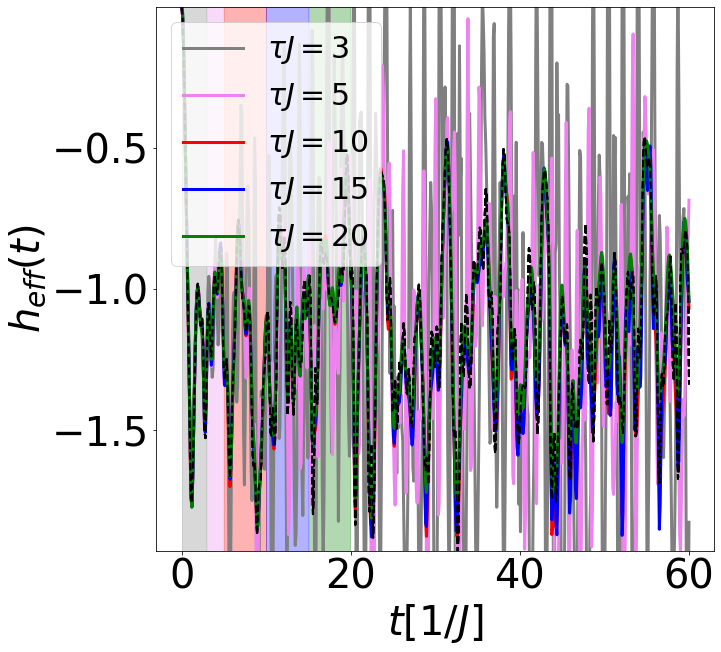

In [84]:
idx=np.random.randint(0,50)
plt.figure(figsize=(10,10))
for i,h_eff_prediction in enumerate(hs_predictions):
    print(i,idx)


    for j in range(1):

        plt.plot(time,h_eff_prediction[idx,1:,j],linewidth=3,label=labels[i],color=colors[i])
        plt.plot(time,h_eff[idx,1 :, j],color='black',linewidth=2,linestyle='--')
        plt.ylabel(r'$h_{eff}(t)$',fontsize=40)
        plt.xlabel(r'$t[1/J]$',fontsize=40)
        #plt.axvline(x=20,color='green',linestyle='--',linewidth=5)
        plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
        plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
        plt.ylim([np.min(h_eff[idx,1:,0]),np.max(h_eff[idx,1:,0])])
plt.fill_between(x=time[:30],y1=-2,y2=2,color=colors[0],alpha=0.3)
plt.fill_between(x=time[30:50],y1=-2,y2=2,color=colors[1],alpha=0.3)
plt.fill_between(x=time[50:100],y1=-2,y2=2,color=colors[2],alpha=0.3)
plt.fill_between(x=time[100:150],y1=-2,y2=2,color=colors[3],alpha=0.3)
plt.fill_between(x=time[150:200],y1=-2,y2=2,color=colors[4],alpha=0.3)
        #plt.xlim([0,40])
plt.legend(fontsize=30)
        
plt.show()

#### Scatter plot with the disorder

(500, 300)


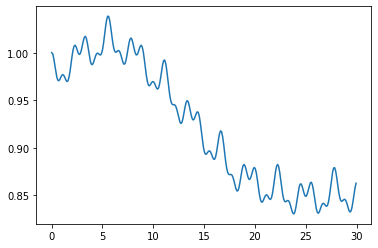

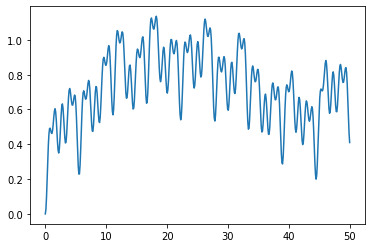

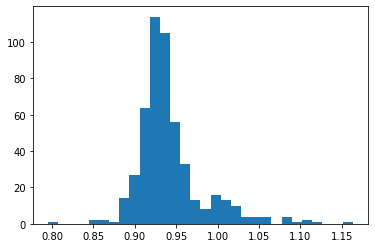

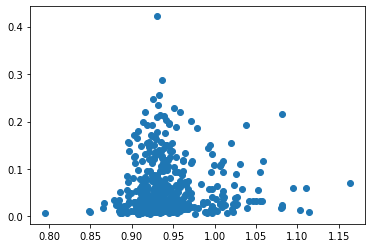

(500, 600, 1)
[ 21.56729798  24.13171928  25.93177043  75.87734302  13.84947822
  27.7682074   48.83270996  38.39332625  34.22473365  53.67310645
  25.94051519  13.01646701  38.73166566  44.92172628  42.35626315
  34.73860526  38.26531953  36.58048225  29.113218    31.76992245
  63.41686846  33.0584238   18.07525506  20.6027613   23.82692137
  33.1646557   49.67422573  34.79601126  65.43518016  25.41438351
  25.33894528  21.45127295  32.90960365  60.83406205  56.90833983
  14.93448921   9.36734658  23.81089431  52.83560199  28.01615123
  94.95751919  31.84952552  30.66522544  59.20232534   9.1207815
  53.595243    52.67261982  37.80654517  34.62049508  39.7522107
  42.86631779  13.92161077  33.25291291  35.02732316  69.85244388
  56.33653043  40.72464537  53.64530485  34.5949063   58.39285738
  19.95596433  31.06098006  13.42398496  45.04739289  65.21131495
  25.88084581  28.08215133  43.98828981  67.93776881  95.97427055
  57.22205757  19.78864582  18.14028126  41.4782434   22.8949564

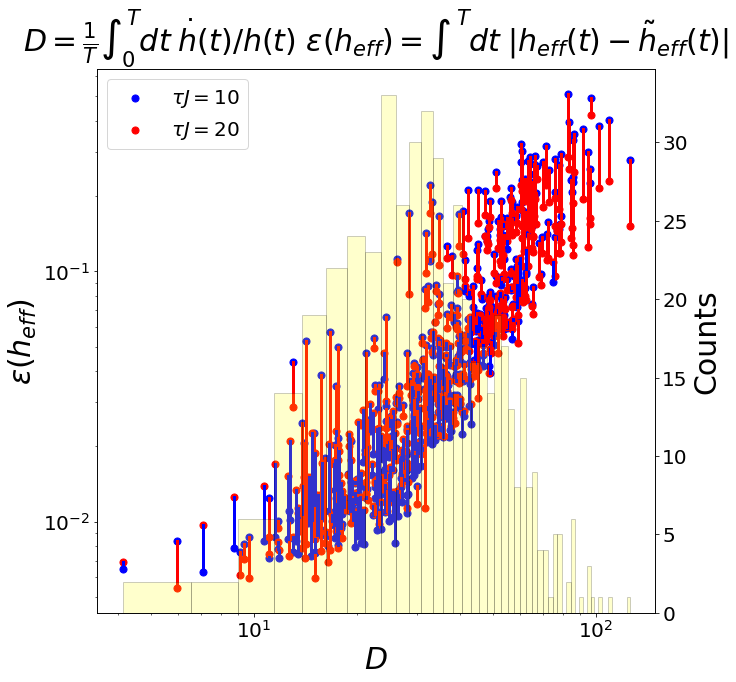

[ 21.56729798  24.13171928  25.93177043  75.87734302  13.84947822
  27.7682074   48.83270996  38.39332625  34.22473365  53.67310645
  25.94051519  13.01646701  38.73166566  44.92172628  42.35626315
  34.73860526  38.26531953  36.58048225  29.113218    31.76992245
  63.41686846  33.0584238   18.07525506  20.6027613   23.82692137
  33.1646557   49.67422573  34.79601126  65.43518016  25.41438351
  25.33894528  21.45127295  32.90960365  60.83406205  56.90833983
  14.93448921   9.36734658  23.81089431  52.83560199  28.01615123
  94.95751919  31.84952552  30.66522544  59.20232534   9.1207815
  53.595243    52.67261982  37.80654517  34.62049508  39.7522107
  42.86631779  13.92161077  33.25291291  35.02732316  69.85244388
  56.33653043  40.72464537  53.64530485  34.5949063   58.39285738
  19.95596433  31.06098006  13.42398496  45.04739289  65.21131495
  25.88084581  28.08215133  43.98828981  67.93776881  95.97427055
  57.22205757  19.78864582  18.14028126  41.4782434   22.89495646
  25.5816190

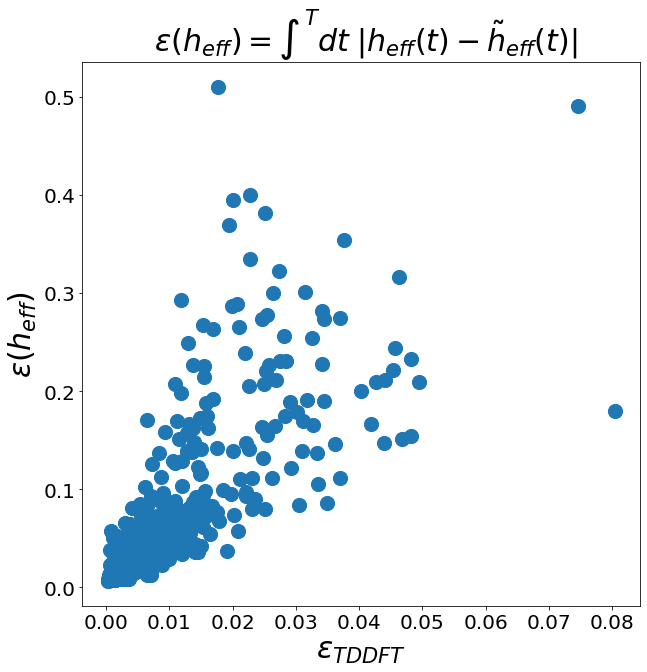

In [95]:

# correlator

idx=np.random.randint(0,50)
h_study=h[:,1:,:]
t=np.arange(time.shape[0]//2)
tau=np.arange(time.shape[0]//2)

matrix_correlator=np.zeros((h_study.shape[0],time.shape[0]//2,time.shape[0]//2))

matrix_correlator=h_study[:,t[:,None],0]*h_study[:,t[:,None]+tau[None,:],0]

correlator=np.average(matrix_correlator,axis=1)

normalized_correlator=correlator/correlator[:,0,None]
print(normalized_correlator.shape)
plt.plot(time[:time.shape[0]//2],normalized_correlator[idx])
plt.show()

plt.plot(time[:500],h_study[idx,:500,0])
plt.show()

average_normalized_correlator=np.average(normalized_correlator,axis=-1)

plt.hist(average_normalized_correlator,bins=30)
plt.show()

plt.scatter(average_normalized_correlator,prediction_errors[-1])
plt.show()

# standard deviation

zero_mean_h_study=h_study-np.average(h_study,axis=1)[:,None,:]
std_h_study=np.std(zero_mean_h_study,axis=1)[:,0]


# speed
print(h_study.shape)
current_h_study=np.gradient(h_study,time,axis=1)
speed=np.average(current_h_study/(h_study+10**-5),axis=1)[:,0]




print(speed)
fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
ax.scatter(speed,prediction_errors[-3],s=50,color='blue',label=labels[-3])
ax.scatter(speed,prediction_errors[-1],s=50,color='red',label=labels[-1])
for i in range(len(prediction_errors[-1])):
    if prediction_errors[-3][i]-prediction_errors[-1][i]>0.:
        ax.plot([speed[i],speed[i]],[prediction_errors[-3][i],prediction_errors[-1][i]],color='red',linewidth=3)
    else:
        ax.plot([speed[i],speed[i]],[prediction_errors[-3][i],prediction_errors[-1][i]],color='blue',linewidth=3)
ax.set_xlabel(r'$D$',fontsize=30)
ax.set_ylabel(r'$\epsilon(h_{eff})$',fontsize=30)
plt.title(r'$D=\frac{1}{T}\int^{T}_0 d t \; \dot{h}(t)/h(t)$ $\epsilon(h_{eff})=\int^T d t \; |h_{eff}(t)-\tilde{h}_{eff}(t)|$',fontsize=30)
ax.tick_params(which='major',labelsize=20)
ax_twin.tick_params(which='major',labelsize=20)
ax_twin.hist(speed,bins=50,edgecolor='black', alpha=0.2,color='yellow')
ax_twin.set_ylabel('Counts',fontsize=30)
ax.loglog()
ax.legend(fontsize=20)
plt.show()


print(speed)
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(dz_average_time,prediction_errors[-3],s=200)
ax.set_xlabel(r'$\epsilon_{TDDFT}$',fontsize=30)
ax.set_ylabel(r'$\epsilon(h_{eff})$',fontsize=30)
plt.title(r' $\epsilon(h_{eff})=\int^T d t \; |h_{eff}(t)-\tilde{h}_{eff}(t)|$',fontsize=30)
ax.tick_params(which='major',labelsize=20)
plt.show()




#### More effective field samples

In [ ]:
#index_sample=np.random.randint(0,maxdata)


# for idx in range(h_eff.shape[-1]):
for i,h_eff_prediction in enumerate(hs_predictions):
    plt.figure(figsize=(10,10))
    plt.plot(time,h_eff_prediction[idx,1:,:2],linestyle='--',linewidth=5,label=labels[i])
    plt.plot(time,h_eff[idx,1 :, :2],color='black',linewidth=2)
    plt.ylabel(r'$h_{eff}(t)$',fontsize=40)
    plt.xlabel(r'$t[1/J]$',fontsize=40)
    #plt.axvline(x=20,color='green',linestyle='--',linewidth=5)
    #plt.legend(fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
    plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
    plt.savefig('effective_field_predictions')
    #plt.fill_between(time[:200], -4.6,-2.1, color='gold', alpha=0.3)
    #plt.ylim([-4.6,-2.1])
    #plt.xlim([0,40])
    plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [96]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip
import numpy as np
from scipy.integrate import solve_ivp

class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [97]:
from scipy.interpolate import interp1d
# build up the operators
x_op=np.array([[0.,1.],[1.,0]],dtype=np.complex128)
z_op=np.array([[1.,0.],[0.,-1.]],dtype=np.complex128)

# maybe there is a problem with the time step



maxdata=20

nsteps=6000

old_steps=600

tf=60.
l=8
j=-1. 
omega=1.

old_time=np.linspace(0,tf,old_steps)
time = np.linspace(0.0, tf,nsteps)
dt=time[1]-time[0]



p=np.random.randint(0,maxdata)

zs_prediction=[] #list for the predictions
for r,h_eff_prediction in enumerate(hs_predictions):
    print(r)
    #slot for the prediction
    z_prediction=np.zeros((maxdata,old_steps,l))
    
    # initialize the effective field with the interpolation
    # to more dense grids
    print(h_eff_prediction.shape)
    old_h_eff=h_eff_prediction[:,1:].copy()
    f=interp1d(old_time,old_h_eff,axis=1)
    h_eff_operation=f(time)
    
    print(h_eff_operation.shape)

    for a in trange(maxdata):
        psi=np.zeros((2,l))
        psi[0] = np.sqrt((1 + z[a,0]) / 2)
        psi[1] = np.sqrt((1 - z[a,0]) / 2)
        h_eff_sample=h_eff_operation[a]
        print(h_eff_sample.shape)
        z_reconstruction=np.zeros((nsteps,l))
        for i in range(nsteps):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi),x_op,psi)
            #pbc
            nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            
            #obc
            # shift_plus=np.zeros(l)
            # shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
            
            
            # shift_minus=np.zeros(l)
            # shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
            # nonlinear_term=j*(shift_plus+shift_minus)+omega
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff_sample[i,0,None,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi=np.einsum('lab,bl->al',exp_h_t,psi)
            psi=psi/np.linalg.norm(psi,axis=0)
            
            z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
            
        z_prediction[a]=np.array([np.interp(old_time, time, z_reconstruction[:, i]) for i in range(z_reconstruction.shape[1])]).T
    
    zs_prediction.append(z_prediction)
        

0
(500, 601, 1)
(500, 6000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(6000, 1)


/tmp/ipykernel_462476/1096167082.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)


  5%|▌         | 1/20 [00:14<04:40, 14.74s/it]

(6000, 1)


 10%|█         | 2/20 [00:25<03:42, 12.38s/it]

(6000, 1)


 15%|█▌        | 3/20 [00:37<03:31, 12.42s/it]

(6000, 1)


 20%|██        | 4/20 [00:51<03:24, 12.77s/it]

(6000, 1)


 25%|██▌       | 5/20 [01:03<03:07, 12.50s/it]

(6000, 1)


 30%|███       | 6/20 [01:14<02:49, 12.09s/it]

(6000, 1)


 35%|███▌      | 7/20 [01:26<02:34, 11.89s/it]

(6000, 1)


 40%|████      | 8/20 [01:37<02:22, 11.88s/it]

(6000, 1)


 45%|████▌     | 9/20 [01:51<02:14, 12.27s/it]

(6000, 1)


 50%|█████     | 10/20 [02:07<02:14, 13.43s/it]

(6000, 1)


 55%|█████▌    | 11/20 [02:21<02:03, 13.74s/it]

(6000, 1)


 60%|██████    | 12/20 [02:37<01:54, 14.30s/it]

(6000, 1)


 65%|██████▌   | 13/20 [02:51<01:40, 14.39s/it]

(6000, 1)


 70%|███████   | 14/20 [03:05<01:26, 14.36s/it]

(6000, 1)


 75%|███████▌  | 15/20 [03:21<01:13, 14.71s/it]

(6000, 1)


 80%|████████  | 16/20 [03:31<00:53, 13.37s/it]

(6000, 1)


 85%|████████▌ | 17/20 [03:48<00:42, 14.26s/it]

(6000, 1)


 90%|█████████ | 18/20 [04:03<00:28, 14.49s/it]

(6000, 1)


 95%|█████████▌| 19/20 [04:13<00:13, 13.30s/it]

(6000, 1)


100%|██████████| 20/20 [04:23<00:00, 13.19s/it]


1
(500, 601, 1)
(500, 6000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(6000, 1)


  5%|▌         | 1/20 [00:14<04:39, 14.71s/it]

(6000, 1)


 10%|█         | 2/20 [00:29<04:27, 14.85s/it]

(6000, 1)


 15%|█▌        | 3/20 [00:44<04:13, 14.88s/it]

(6000, 1)


 20%|██        | 4/20 [00:58<03:49, 14.33s/it]

(6000, 1)


 25%|██▌       | 5/20 [01:08<03:15, 13.05s/it]

(6000, 1)


 30%|███       | 6/20 [01:21<03:01, 12.98s/it]

(6000, 1)


 35%|███▌      | 7/20 [01:35<02:50, 13.11s/it]

(6000, 1)


 40%|████      | 8/20 [01:50<02:45, 13.82s/it]

(6000, 1)


 45%|████▌     | 9/20 [02:05<02:35, 14.11s/it]

(6000, 1)


 50%|█████     | 10/20 [02:20<02:23, 14.36s/it]

(6000, 1)


 55%|█████▌    | 11/20 [02:34<02:09, 14.41s/it]

(6000, 1)


 60%|██████    | 12/20 [02:50<02:00, 15.00s/it]

(6000, 1)


 65%|██████▌   | 13/20 [03:11<01:56, 16.71s/it]

(6000, 1)


 70%|███████   | 14/20 [03:27<01:38, 16.44s/it]

(6000, 1)


 75%|███████▌  | 15/20 [03:43<01:20, 16.19s/it]

(6000, 1)


 80%|████████  | 16/20 [03:55<01:00, 15.17s/it]

(6000, 1)


 85%|████████▌ | 17/20 [04:10<00:44, 14.95s/it]

(6000, 1)


 90%|█████████ | 18/20 [04:25<00:30, 15.18s/it]

(6000, 1)


 95%|█████████▌| 19/20 [04:42<00:15, 15.45s/it]

(6000, 1)


100%|██████████| 20/20 [04:55<00:00, 14.75s/it]


2
(500, 601, 1)
(500, 6000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(6000, 1)


  5%|▌         | 1/20 [00:16<05:08, 16.25s/it]

(6000, 1)


 10%|█         | 2/20 [00:35<05:20, 17.82s/it]

(6000, 1)


 15%|█▌        | 3/20 [00:49<04:39, 16.42s/it]

(6000, 1)


 20%|██        | 4/20 [01:05<04:16, 16.00s/it]

(6000, 1)


 25%|██▌       | 5/20 [01:19<03:50, 15.38s/it]

(6000, 1)


 30%|███       | 6/20 [01:32<03:24, 14.60s/it]

(6000, 1)


 35%|███▌      | 7/20 [01:48<03:14, 15.00s/it]

(6000, 1)


 40%|████      | 8/20 [02:11<03:28, 17.40s/it]

(6000, 1)


 45%|████▌     | 9/20 [02:22<02:50, 15.47s/it]

(6000, 1)


 50%|█████     | 10/20 [02:33<02:22, 14.23s/it]

(6000, 1)


 55%|█████▌    | 11/20 [02:47<02:07, 14.19s/it]

(6000, 1)


 60%|██████    | 12/20 [03:03<01:56, 14.52s/it]

(6000, 1)


 65%|██████▌   | 13/20 [03:19<01:45, 15.02s/it]

(6000, 1)


 70%|███████   | 14/20 [03:31<01:25, 14.19s/it]

(6000, 1)


 75%|███████▌  | 15/20 [03:43<01:07, 13.45s/it]

(6000, 1)


 80%|████████  | 16/20 [03:58<00:56, 14.11s/it]

(6000, 1)


 85%|████████▌ | 17/20 [04:16<00:45, 15.18s/it]

(6000, 1)


 90%|█████████ | 18/20 [04:33<00:31, 15.60s/it]

(6000, 1)


 95%|█████████▌| 19/20 [04:53<00:17, 17.01s/it]

(6000, 1)


100%|██████████| 20/20 [05:09<00:00, 15.47s/it]


3
(500, 601, 1)
(500, 6000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(6000, 1)


  5%|▌         | 1/20 [00:15<04:46, 15.06s/it]

(6000, 1)


 10%|█         | 2/20 [00:31<04:48, 16.05s/it]

(6000, 1)


 15%|█▌        | 3/20 [00:50<04:54, 17.34s/it]

(6000, 1)


 20%|██        | 4/20 [01:10<04:53, 18.37s/it]

(6000, 1)


 25%|██▌       | 5/20 [01:26<04:24, 17.65s/it]

(6000, 1)


 30%|███       | 6/20 [01:42<03:56, 16.92s/it]

(6000, 1)


 35%|███▌      | 7/20 [01:55<03:23, 15.66s/it]

(6000, 1)


 40%|████      | 8/20 [02:09<03:00, 15.06s/it]

(6000, 1)


 45%|████▌     | 9/20 [02:26<02:52, 15.66s/it]

(6000, 1)


 50%|█████     | 10/20 [02:43<02:41, 16.20s/it]

(6000, 1)


 55%|█████▌    | 11/20 [02:58<02:22, 15.80s/it]

(6000, 1)


 60%|██████    | 12/20 [03:15<02:08, 16.02s/it]

(6000, 1)


 65%|██████▌   | 13/20 [03:32<01:54, 16.42s/it]

(6000, 1)


 70%|███████   | 14/20 [03:45<01:32, 15.35s/it]

(6000, 1)


 75%|███████▌  | 15/20 [04:00<01:16, 15.38s/it]

(6000, 1)


 80%|████████  | 16/20 [04:19<01:06, 16.53s/it]

(6000, 1)


 85%|████████▌ | 17/20 [04:33<00:46, 15.63s/it]

(6000, 1)


 90%|█████████ | 18/20 [04:49<00:31, 15.86s/it]

(6000, 1)


 95%|█████████▌| 19/20 [05:02<00:14, 14.90s/it]

(6000, 1)


100%|██████████| 20/20 [05:16<00:00, 15.85s/it]


4
(500, 601, 1)
(500, 6000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(6000, 1)


  5%|▌         | 1/20 [00:13<04:21, 13.74s/it]

(6000, 1)


 10%|█         | 2/20 [00:31<04:46, 15.90s/it]

(6000, 1)


 15%|█▌        | 3/20 [00:48<04:39, 16.42s/it]

(6000, 1)


 20%|██        | 4/20 [01:07<04:38, 17.41s/it]

(6000, 1)


 25%|██▌       | 5/20 [01:21<04:05, 16.39s/it]

(6000, 1)


 30%|███       | 6/20 [01:33<03:29, 14.95s/it]

(6000, 1)


 35%|███▌      | 7/20 [01:47<03:07, 14.43s/it]

(6000, 1)


 40%|████      | 8/20 [02:01<02:51, 14.32s/it]

(6000, 1)


 45%|████▌     | 9/20 [02:16<02:40, 14.63s/it]

(6000, 1)


 50%|█████     | 10/20 [02:28<02:18, 13.89s/it]

(6000, 1)


 55%|█████▌    | 11/20 [02:40<01:58, 13.13s/it]

(6000, 1)


 60%|██████    | 12/20 [02:51<01:40, 12.62s/it]

(6000, 1)


 65%|██████▌   | 13/20 [03:10<01:41, 14.46s/it]

(6000, 1)


 70%|███████   | 14/20 [03:22<01:22, 13.76s/it]

(6000, 1)


 75%|███████▌  | 15/20 [03:36<01:08, 13.74s/it]

(6000, 1)


 80%|████████  | 16/20 [03:51<00:56, 14.18s/it]

(6000, 1)


 85%|████████▌ | 17/20 [04:07<00:44, 14.89s/it]

(6000, 1)


 90%|█████████ | 18/20 [04:24<00:30, 15.23s/it]

(6000, 1)


 95%|█████████▌| 19/20 [04:36<00:14, 14.42s/it]

(6000, 1)


100%|██████████| 20/20 [04:48<00:00, 14.44s/it]


 PBC

15


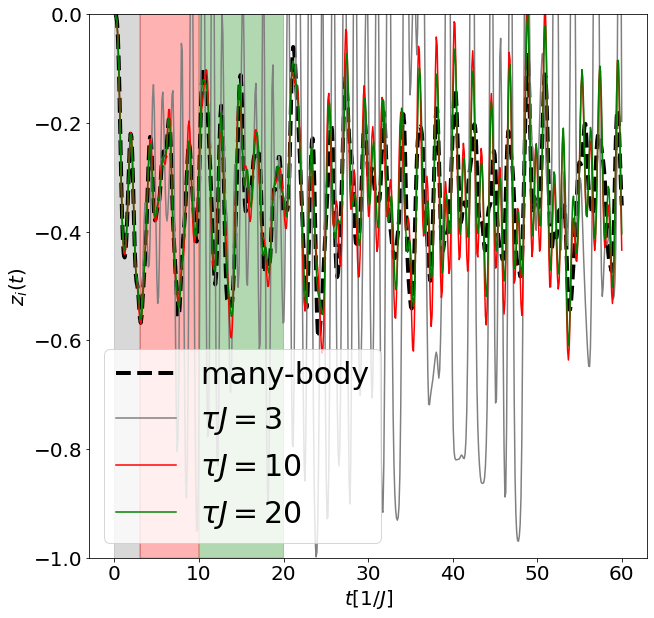

In [ ]:
idx=np.random.randint(0,maxdata)
fig,ax=plt.subplots(figsize=(10,10))
r=0
idx=15
print(idx)
ax.plot(old_time,z[idx,:,r],color='black',label='many-body',linestyle='--',linewidth=4)
#ax.plot(old_time,zs_prediction[0][idx,:,r],color=colors[0],label=labels[0])
ax.plot(old_time,zs_prediction[1][idx,:,r],color=colors[1],label=labels[1])
ax.plot(old_time,zs_prediction[2][idx,:,r],color=colors[2],label=labels[2])
ax.plot(old_time,zs_prediction[-1][idx,:,r],color=colors[-1],label=labels[-1])

if i==0 and j==0:
    ax.legend(fontsize=30)
ax.set_ylabel(r'$z_i(t)$',fontsize=20)
ax.set_xlabel(r'$t[1/J]$',fontsize=20)
ax.tick_params(which='major',labelsize=20)
#plt.fill_between(x=time[:300],y1=-1,y2=1,color=colors[0],alpha=0.3)
plt.fill_between(x=time[0:500],y1=-1,y2=1,color=colors[1],alpha=0.3)
plt.fill_between(x=time[500:1000],y1=-1,y2=1,color=colors[2],alpha=0.3)
#plt.fill_between(x=time[1000:1500],y1=-1,y2=1,color=colors[3],alpha=0.3)
plt.fill_between(x=time[1000:2000],y1=-1,y2=1,color=colors[4],alpha=0.3)
plt.legend(fontsize=30)
plt.savefig('images/magnetization_results_obc_training_driving')
plt.ylim([-1,0])
plt.show()

In [ ]:
idx=np.random.randint(0,maxdata)
fig,ax=plt.subplots(4,2,figsize=(17,20))

for i in range(4):
    for j in range(2):
        r=(i)+4*j
        ax[i,j].plot(old_time,z[idx,:,r],color='black',label='many-body')
        #ax[i,j].plot(old_time,zs_prediction[0][idx,:,r],color='red',linestyle='--',label='auxiliary')
        #ax[i,j].plot(old_time,zs_prediction[1][idx,:,r],color='green',linestyle='--',label='auxiliary')
        ax[i,j].plot(old_time,zs_prediction[2][idx,:,r],color='blue',linestyle='--',label='auxiliary')
        if i==0 and j==0:
            ax[i,j].legend(fontsize=30)
        ax[i,j].set_ylabel(r'$z_i(t)$',fontsize=20)
        ax[i,j].set_xlabel(r'$t[1/J]$',fontsize=20)
        ax[i,j].tick_params(which='major',labelsize=20)
        ax[i,j].fill_between(old_time[:100], -1,1, color='gold', alpha=0.3)
        #ax[i,j].set_ylim([-1,-0.7])
        #ax[i,j].set_xlim([0,40])
        
plt.savefig('images/magnetization_results_obc_training_driving')
#plt.xlim([0,0.01])
plt.show()


(500, 200, 1)
(20, 200, 8)
(200,)
(200,)
(200,)
(200,)
(200,)


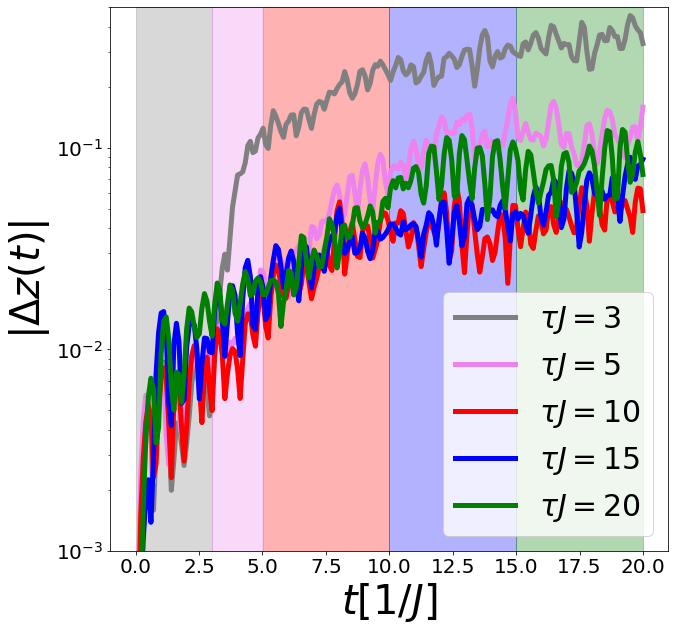

In [ ]:
print(z.shape)
print(z_prediction.shape)
plt.figure(figsize=(10,10))
dzs=[]
for i in range(5):
    dz=np.average(np.average(np.abs(zs_prediction[i]-z[:maxdata,:,:]),axis=-1),axis=0)
    dzs.append(dz)
    print(dz.shape)
    
    q=0
    plt.plot(old_time,dz,linewidth=5,color=colors[i],label=labels[i])
plt.fill_between(x=time[:300],y1=0,y2=1,color=colors[0],alpha=0.3)
plt.fill_between(x=time[300:500],y1=0,y2=1,color=colors[1],alpha=0.3)
plt.fill_between(x=time[500:1000],y1=0,y2=1,color=colors[2],alpha=0.3)
plt.fill_between(x=time[1000:1500],y1=0,y2=1,color=colors[3],alpha=0.3)
plt.fill_between(x=time[1500:2000],y1=0,y2=1,color=colors[4],alpha=0.3)

plt.semilogy()
plt.legend(fontsize=30)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z (t)|$',fontsize=40)
plt.ylim([10**-3,0.5])
plt.tick_params(which='major',labelsize=20)
plt.savefig('images/magnetization_error_obc_training_driving')
plt.show()

#### Correlation between the $h_{eff}(t)$ error and $z(t)$

R^2= 0.7675827839363549 slope= 1.277901031095712


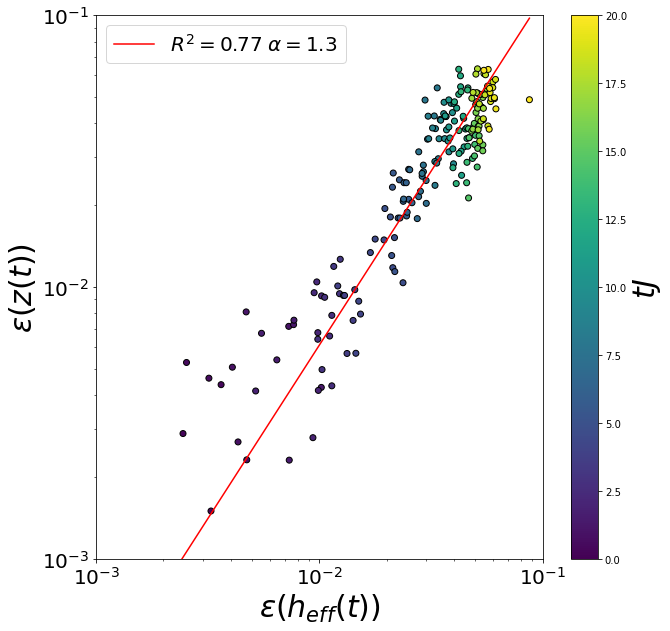

In [ ]:
# fit using chatgpt
x=np.log(dheffs[-3])
y=np.log(dzs[-3])

coefficients = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
slope, intercept = coefficients
y_pred = np.polyval(coefficients, x)  # Predicted y values

# Calculate R^2
ss_res = np.sum((y - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)



print('R^2=',r_squared,'slope=',slope)
plt.figure(figsize=(10,10))
time_plot=np.linspace(0,20,200)


plt.scatter(dheffs[-3],dzs[-3],c=time_plot, cmap='viridis', edgecolor='k')
plt.plot(dheffs[-3],np.exp(intercept)*dheffs[-3]**slope,color='red',label=r'$R^2=$'+f'{r_squared:.2f}'+r'$\; \alpha=$'+f'{slope:.2}')
#plt.scatter(dheffs[-3][time_plot>10],dzs[-3][time_plot>10],color='red')
clbar=plt.colorbar()
clbar.set_label(r'$tJ$',fontsize=30)
plt.xlabel(r'$\epsilon(h_{eff}(t))$',fontsize=30)
plt.ylabel(r'$\epsilon(z(t))$',fontsize=30)
plt.tick_params(labelsize=20,)
plt.ylim(10**-3,0.1)
plt.xlim(10**-3,0.1)
plt.loglog()
plt.legend(fontsize=20)
plt.show()





#### Test a different field

#### Compute the Hamiltonian

In [ ]:
class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

nbatch = 1

l = 8
# rates = [0.1, 0.5, 0.8, 1.0]

# j coupling
j = 1
# omega auxiliary field
maxdata=1
omega = 1
maxdata=1
rate_max=1.
rate_min=0.1

amplitude_max=1
amplitude_min=0.1

steps = 600
tf = 60.0
time = np.linspace(0.0, tf, steps)
gamma=1

ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=False,
    coupling_values=[j],
    size=l,
)

hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

obs: List[qutip.Qobj] = []
current_obs: List[qutip.Qobj] = []

for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    #pbc
    # current = SpinOperator(
    #     index=[("x", (i - 1) % l, "y", i), ("y", i, "x", (i + 1) % l)],
    #     coupling=[2 * j, 2 * j],
    #     size=l,
    # )
    #obc
    print(l)
    # if i-1 >=0 and i+1<=l-1:
    #     current = SpinOperator(
    #         index=[("x", (i - 1) , "y", i), ("y", i, "x", (i + 1) )],
    #         coupling=[2 * j, 2 * j],
    #         size=l,
    #     )

    obs.append(z_op.qutip_op)
    # current_obs.append(current.qutip_op)

heffs=np.zeros((maxdata,steps,l))
hs=np.zeros_like(heffs)
z=np.zeros((maxdata,steps,l))    


for a in trange(maxdata):
    final_value=1
    initial_value=2
    hf=final_value*np.ones((time.shape[0], l))
    hi=initial_value*np.ones((time.shape[0], l))

    # rate = np.random.uniform(0.3, 1.0)

    rate_cutoff = 15
    rate=np.random.uniform(rate_min,rate_max,size=rate_cutoff)
    delta = np.random.uniform(amplitude_min,amplitude_max,size=(rate_cutoff))

    h = (
        delta[:, None, None]
        * np.sin(time[None, :, None] * rate[:, None, None])
        + hi
    )

    #h=np.exp(-time*gamma)[:,None]*hi[None,:]+(1-np.exp(-time*gamma)[:,None])*hf[None,:]
    #h=h[0]

    h = np.average(h, axis=0)
    print(h.shape)
    h=hi*np.exp(-time*gamma)[:,None]+(1-np.exp(-time*gamma)[:,None])*hf[None,:]

    h=h[0]
    
    plt.figure(figsize=(10,10))
    plt.plot(time,h,color='black',linewidth=3)
    plt.xlabel(r'$t[1/J]$',fontsize=40)
    plt.ylabel(r'$h(t)$',fontsize=40)
    plt.tick_params(which='major',labelsize=30)
    plt.savefig(f'images/quench_driving_gamma_{gamma:.0f}')
    plt.show()
    print(h.shape)
    hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

    eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
        eigvals=1
    )
    psi0 = psi0[
        0
    ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))

    print("real ground state energy=", eng[0])

    hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

    for i in range(l):
        drive_z = Driving(
            h=h,
            dt=time[1] - time[0],
            idx=i,
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution and

    output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs)

    current_exp = np.zeros((steps, l))
    z_exp = np.zeros_like(current_exp)

    for r in range(l):
        z_exp[:, r] = output.expect[r]
        

    # Current derivative
    current_exp=np.gradient(z_exp, time, axis=0)
    current_derivative = np.gradient(current_exp, time, axis=0)

    # compute the effective field
    x_sp = np.sqrt(1 - z_exp**2) * np.cos(
        np.arcsin(-1 * (current_exp) / (2 * np.sqrt(1 - z_exp**2)))
    )


    current_derivative = np.gradient(current_exp, time, axis=0)
    #plt.plot(current_derivative)
    #pbc
    # nonlinear_term=j*(np.roll(x_sp,shift=1,axis=-1)+np.roll(x_sp,shift=-1,axis=-1))
    # plt.plot(nonlinear_term)
    # part_1=0.25*current_derivative/(nonlinear_term+omega)
    # part_2=(nonlinear_term+omega)*z_exp
    # h_eff = (part_1 + part_2) / (x_sp + 10**-4)

    #obc
    shift_plus=np.zeros((time.shape[0],l))
    shift_plus[:,1:]=x_sp[:,1:] #np.roll(x_sp,shift=1,axis=-1)
    shift_minus=np.zeros((time.shape[0],l))
    shift_minus[:,:-1]=x_sp[:,:-1] #np.roll(x_sp,shift=-1,axis=-1)
    nonlinear_term=j*(shift_plus+shift_minus)
    part_1=0.25*current_derivative/(nonlinear_term+omega)
    part_2=(nonlinear_term+omega)*z_exp
    h_eff = (part_1 + part_2) / (x_sp + 10**-20)
    
    heffs[a]=h_eff
    hs[a]=h
    z[a]=z_exp


In [ ]:
print(h.shape)
print(h_eff.shape)
print(z.shape,hs.shape)
input=np.append(z[:,0].reshape(-1,1,l),hs,axis=1)


heff_prediction,_=model(torch.from_numpy(input))
heff_prediction=heff_prediction.detach().numpy()
print(heff_prediction.shape)
plt.plot(time,heff_prediction[0,1:],color='red',linestyle='--')
plt.plot(time,heffs[0,:],color='black',linestyle='-')
plt.show()


p=np.random.randint(0,maxdata)

plt.figure(figsize=(10,10))
plt.plot(time,hs[p],color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,heff_prediction[p,1:],color='red',linestyle='--',linewidth=4,)
plt.plot(time,heffs[p],color='black',linewidth=4,)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h_{eff,i}(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.title('red line prediction, black line exact',fontsize=30)
plt.savefig(f'images/periodic_effective_field_gamma_{gamma:.0f}')
plt.show()


dheff=np.average(np.abs(heff_prediction[:,1:]-heffs),axis=(0,-1))

plt.figure(figsize=(10,10))
plt.plot(time,dheff,color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta h_{eff}(t)|$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.show()


In [ ]:
from scipy.interpolate import interp1d
# build up the operators
x_op=np.array([[0.,1.],[1.,0]],dtype=np.complex128)
z_op=np.array([[1.,0.],[0.,-1.]],dtype=np.complex128)


nsteps=600
tf=60.
l=8
j=1. 
omega=1.
time = np.linspace(0.0, tf,nsteps)
dt=time[1]-time[0]

p=np.random.randint(0,maxdata)


z_prediction=np.zeros((maxdata,nsteps,l))

print(hs_predictions[0][p,:2])
for a in trange(maxdata):
    psi=np.zeros((2,l))
    psi[0] = np.sqrt((1 + z[a,0]) / 2)
    psi[1] = np.sqrt((1 - z[a,0]) / 2)
    h_eff_sample=heff_prediction[a,1:]
    z_reconstruction=np.zeros((nsteps,l))
    for i in range(nsteps):
        x_ave=np.einsum('al,ab,bl->l',np.conj(psi),x_op,psi)
        #pbc
        #nonlinear_term=j*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
        
        #obc
        shift_plus=np.zeros(l)
        shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
        shift_minus=np.zeros(l)
        shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
        nonlinear_term=j*(shift_plus+shift_minus)+omega
        hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff_sample[i,:,None,None]*z_op[None,:,:]
        exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
        for r in range(l):
            exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
        #print(exp_h_t)    
        psi=np.einsum('lab,bl->al',exp_h_t,psi)
        psi=psi/np.linalg.norm(psi,axis=0)
        
        z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
    z_prediction[a]=z_reconstruction

In [ ]:
fig,ax=plt.subplots(4,2,figsize=(40,60))
for i in range(4):
    for j in range(2):
        r=(i)+4*(j)
        ax[i,j].plot(time,z_prediction[p,:,r],color='red',linestyle='--',linewidth=5)
        ax[i,j].plot(time,z[p,:,r],color='black',linestyle='-',linewidth=5)
        ax[i,j].tick_params(which='major',labelsize=30)
        ax[i,j].set_xlabel(r'$t[1/J]$',fontsize=40)
        ax[i,j].set_ylabel(r'$z_i(t)$',fontsize=40)
        ax[i,j].set_title(f'i={r}',fontsize=40)
plt.show()

dz=np.average(np.abs(z_prediction-z),axis=(0,-1))
plt.figure(figsize=(10,10))
plt.plot(time,dz,color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z(t)|$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.savefig(f'images/magnetization_results_inverse_quench_gamma_{gamma:.0f}')
plt.show()


In [ ]:
l =1
steps = 400
tf = 40.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)

zs_prediction=[]
for j in range(10):

    for idx in range(l):
        psi0 = np.zeros(2)
        psi0[0] = np.sqrt((1 + zs[j, 0]) / 2)
        psi0[1] = np.sqrt((1 - zs[j, 0]) / 2)
        
        if idx==0:
            psi=psi0
        else:
            psi=np.kron(psi,psi0)
            
    psi0 = qutip.Qobj(
        psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
    )



    # Measure observable
    obs:List=[]
    for i in range(l):
        obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)


    # build up the time dependent object for the qutip evolution
    hamiltonian = [ham0.qutip_op]
    for i in range(l):
        drive_z = Driving(
            h=
                h_eff_prediction[j,1:]
            ,
            idx=i,
            dt=time[1] - time[0],
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution
    output = qutip.sesolve(
        hamiltonian,
        psi0,
        time,
        e_ops=obs
    )

    z_prediction=np.zeros((time.shape[0],l))
    for r in range(l):
        z_prediction[:, r] = output.expect[r]
    
    zs_prediction.append(z_prediction)

zs_prediction=np.asarray(zs_prediction)
    

In [ ]:
print(zs.shape,zs_prediction.shape)
dz=np.average(np.abs(zs_prediction[:,:,0]-zs[:,:]),axis=0)

plt.plot(time,dz)
plt.xlabel(r'$t [1/J]$',fontsize=30)
plt.ylabel(r'$|\Delta z (t)|$',fontsize=40)

plt.show()


for i in range(10):
    
    plt.plot(time,zs[i])
    plt.plot(time,zs_prediction[i])
    plt.show()

In [ ]:
plt.plot(time,z_exp)
plt.plot(time,z_prediction)
plt.show()

## DL-effective field and computation via auxiliary system (LSTM) analysis different training dataset size

#### Imports

In [3]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import field2field_mapping

torch.set_num_threads(3)

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


ModuleNotFoundError: No module named 'src.tddft_methods.field2field_utils'

#### Data

In [2]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip
from scipy.sparse.linalg import eigsh,expm

data = np.load(
    "data/dataset_h_eff/new_analysis_xxzx_model/dataset_2025-02-01_18-24.npz"
)

maxdata=500
print(data['info'])
print(data['comments'])
time=np.linspace(0,20,200)

ModuleNotFoundError: No module named 'src.training.models_adiabatic'

In [83]:


h = data["h"][-maxdata:]
h_eff = data["h_eff"][-maxdata:]
z=data['z'][-maxdata:]
z_auxiliary=data['z_auxiliary'][-maxdata:]
print(h.shape)

models=[]

labels=[r'$N_{tr}=10^3$',r'$N_{tr}=5 \cdot 10^3$',r'$N_{tr}=10 \cdot 10^3$',r'$N_{tr}=20 \cdot 10^3$']
models_name=['LSTM_f2f_fixed_initial_state_tf_20_250203_dataset_10k_[1000]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock']
#models_name=['LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240625_dataset_20k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240628_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_200_tf_40_240629_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock']
for i,name in enumerate(models_name):
    model = torch.load(
    "model_rep/new_analysis_lstm_field2field/"+name,
    map_location="cpu",
    )
    model.eval()
    models.append(model)
    print(model)
# Loading the model


(500, 201, 1)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)
LSTMTDDFT(
  (model): LSTM(1, 500, proj_size=1, num_layers=4, batch_first=True)
  (loss): MSELoss()
)


#### Save sample for Carlos

In [ ]:
h_flat=h[:5,1:,0]

data_to_save = np.column_stack((time, h_flat.T))  # Transpose h_flat to align with time

# Save to a single .txt file
filename = 'drivings.txt'
header = 'Time    driving_1    driving_2    driving_3    driving_4    driving_5'
np.savetxt(filename, data_to_save, fmt='%.6f', header=header, comments='')

print(f"Saved all signals to {filename}")

Saved all signals to drivings.txt


#### Analysis of the dataset and the TDDFT accuracy

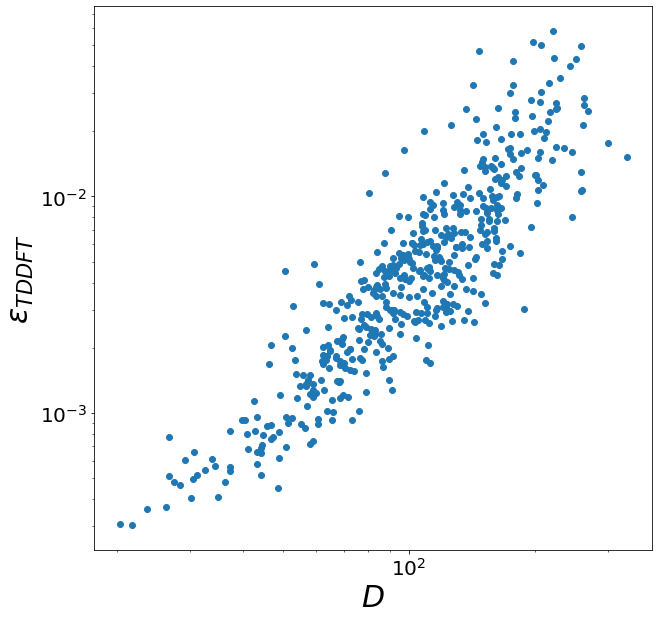

In [ ]:
h_study=h[:,1:]
current_h_study=np.gradient(h_study,time,axis=1)
speed=np.average(current_h_study/(h_study+10**-5),axis=1)[:,0]

dz_average_time=np.average(np.average(np.abs(z[:,:]-z_auxiliary[:,:]),axis=-1),axis=1)

plt.figure(figsize=(10,10))
plt.scatter(speed,dz_average_time)
plt.xlabel(r'$D$',fontsize=30)
plt.ylabel(r'$\epsilon_{TDDFT}$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.loglog()
plt.show()


#### Structure of the Driving

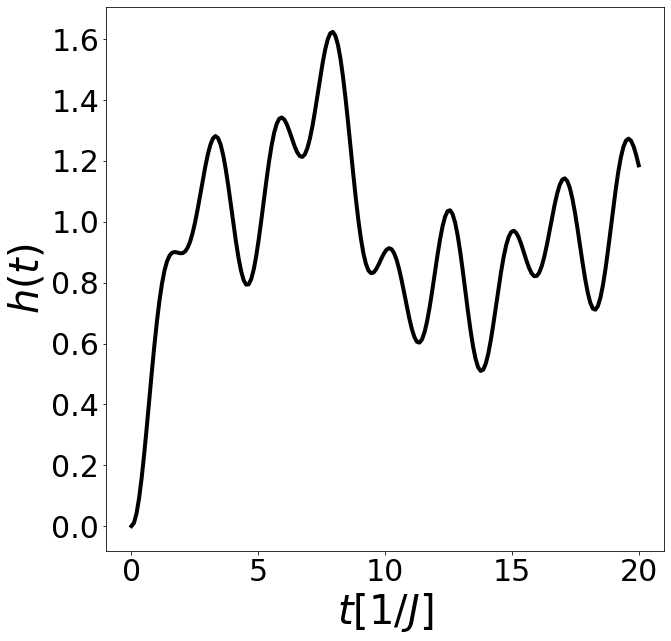

In [ ]:
idx= np.random.randint(0,maxdata)

plt.figure(figsize=(10,10))
plt.plot(time,h[idx,1:,:],color='black',linewidth=4)
plt.xlabel(r'$t [1/J]$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.savefig('images/sample_driving_obc_training_dataset')
plt.show()

#### $h_{eff}(t)$ from the DL mapping

In [84]:
hs_predictions=[]
for model in models:

    h_eff_prediction,_=model(torch.tensor(h))
    h_eff_prediction = h_eff_prediction.detach().numpy()
    # h_eff_prediction=np.einsum('bit->bti',h_eff_prediction)
    print(h_eff_prediction.shape)
    hs_predictions.append(h_eff_prediction)    

(500, 201, 1)
(500, 201, 1)
(500, 201, 1)
(500, 201, 1)


#### Errors

(200,)
(200,)
(200,)
(200,)


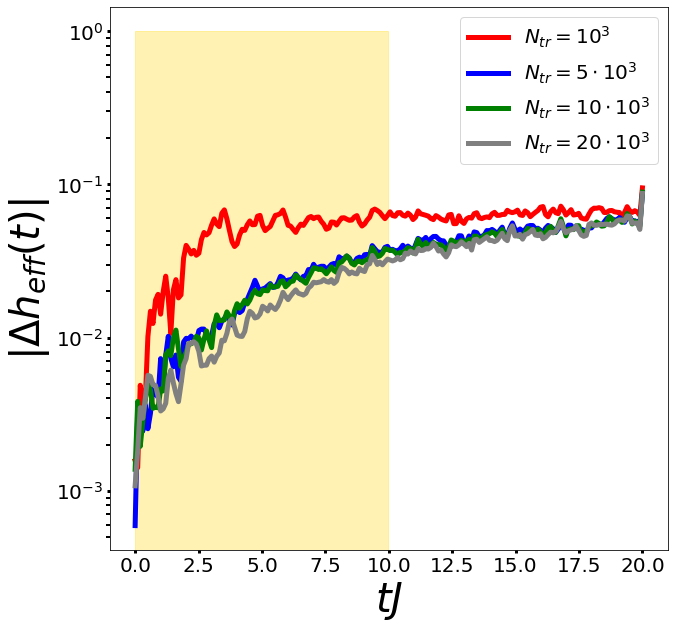

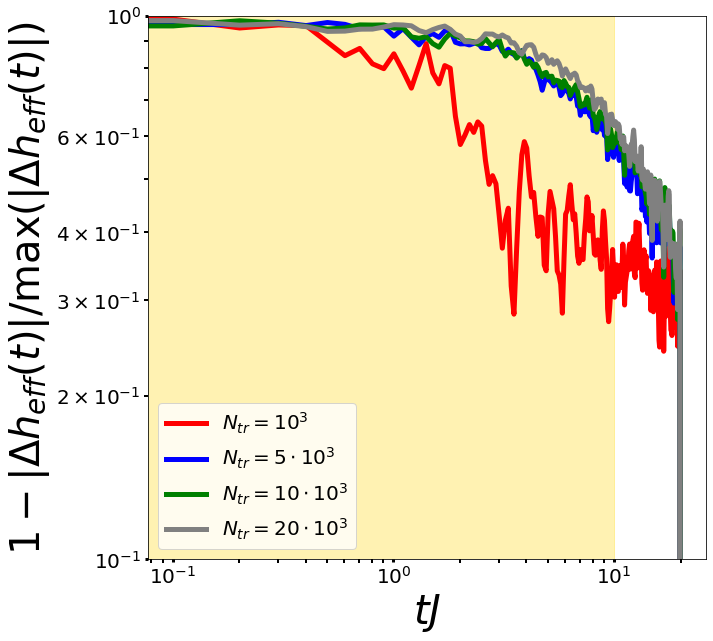

In [89]:
colors=['red','blue','green','grey']

plt.figure(figsize=(10,10))
prediction_errors=[]
for i, h_eff_prediction in enumerate(hs_predictions):
    #dh_eff=np.average(np.abs(h_eff_prediction-h_eff),axis=0)
    dh_eff=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=0)#/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)
    dh_eff_average_time=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=1)
    prediction_errors.append(dh_eff_average_time)

    print(dh_eff.shape)

    plt.plot(time,dh_eff[:],linewidth=5,label=labels[i],color=colors[i])
    
plt.tick_params(which='major',labelsize=20,length=3,width=3)
plt.tick_params(which='minor',labelsize=20,length=4,width=2)
plt.xlabel(r'$t J$',fontsize=40)
plt.fill_between(x=time[:100],y1=0,y2=1,color='gold',alpha=0.3)

plt.ylabel(r'$|\Delta h_{eff}(t)|$',fontsize=40)
plt.legend(fontsize=20)
plt.semilogy()
plt.savefig('images/effective_field_error_obc')
plt.show()


# plot with the normalized condition

plt.figure(figsize=(10,10))
for i, h_eff_prediction in enumerate(hs_predictions):
    #dh_eff=np.average(np.abs(h_eff_prediction-h_eff),axis=0)
    dh_eff=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1),axis=0)#/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)

    max_dheff=np.max(dh_eff)
    normalized_dheff=dh_eff/max_dheff
    plt.plot(time,1-normalized_dheff+10**-3,linewidth=5,label=labels[i],color=colors[i])
    
plt.tick_params(which='major',labelsize=20,length=3,width=3)
plt.tick_params(which='minor',labelsize=20,length=4,width=2)
plt.xlabel(r'$t J$',fontsize=40)
plt.fill_between(x=time[:100],y1=0,y2=1,color='gold',alpha=0.3)

plt.ylim([10**-1,1])
plt.ylabel(r'$1-|\Delta h_{eff}(t)|/\mathrm{max}(|\Delta h_{eff}(t)|)$',fontsize=40)
plt.legend(fontsize=20)
plt.loglog()
plt.savefig('images/effective_field_error_obc')
plt.show()



#### Check the comparison with the exact $h_{eff}(t)$

0 16
1 16
2 16
3 16


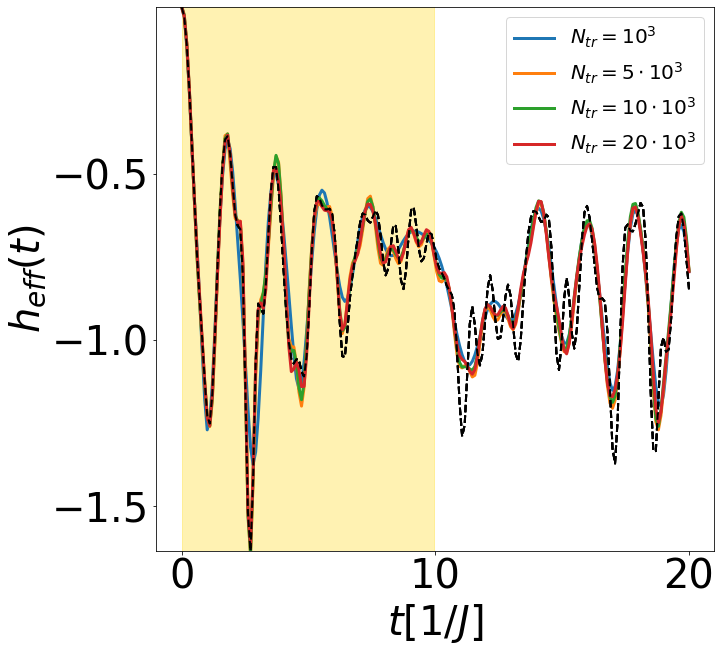

In [99]:
idx=np.random.randint(0,50)
plt.figure(figsize=(10,10))
for i,h_eff_prediction in enumerate(hs_predictions):
    print(i,idx)


    for j in range(1):

        plt.plot(time,h_eff_prediction[idx,1:,j],linewidth=3,label=labels[i])
        plt.plot(time,h_eff[idx,1 :, j],color='black',linewidth=2,linestyle='--')
        plt.ylabel(r'$h_{eff}(t)$',fontsize=40)
        plt.xlabel(r'$t[1/J]$',fontsize=40)
        #plt.axvline(x=20,color='green',linestyle='--',linewidth=5)
        plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
        plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
plt.fill_between(time[0:100], -3,3, alpha=0.3,color='gold')
plt.ylim([np.min(h_eff[idx,1:,0]),np.max(h_eff[idx,1:,0])])
plt.legend(fontsize=20)
        
plt.show()

#### Scatter plot with the disorder

(500, 100)


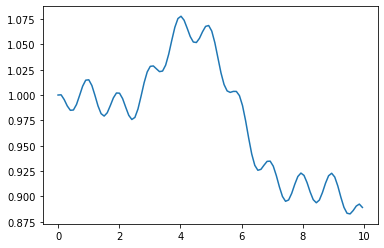

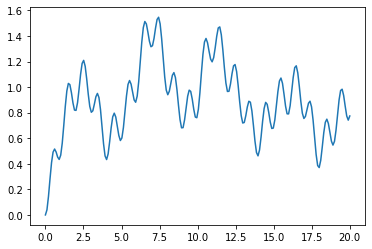

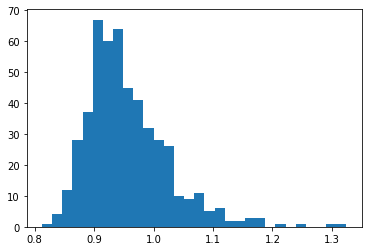

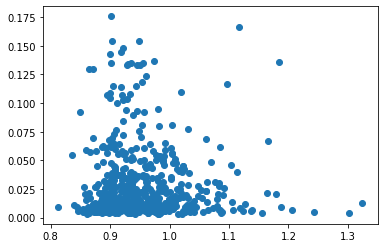

(500, 200, 1)
[133.8506202  129.58940134 152.9125904   59.1417686  177.24452921
  91.0079376   86.31177997  83.32869915  96.95451943 158.10328473
 138.56721378 119.39048752  81.18839796 170.24697478  82.41268917
 155.56990938 153.82012943 118.80224884 224.5339076   46.83276022
 152.09427979  95.78566153 102.72004468 204.05530968  81.10291545
  70.02201097  65.51951034 245.52645962  66.90313771  40.44367047
  64.52326328 149.22302121 102.9750033  159.6593344   83.17291188
  79.27416698 196.24395684  83.81596582 101.29981512 166.02675334
 116.00144653 128.14933146  69.18096346 103.35852439 243.50376317
  75.59723367  95.61459757  88.05908571 159.82575213  77.98605453
  70.35324192  95.07543251 165.90865251 125.81511498 107.80770308
  62.96229818  91.77861844 127.84113217 166.26674968  53.9552153
  26.68136557  97.38923516  82.34458862  91.88919014  48.66948932
  98.88574106  48.89707088  78.03885688  62.27710748 120.61140003
  76.19403209  52.6206505  147.50163662  50.82285584 145.333107

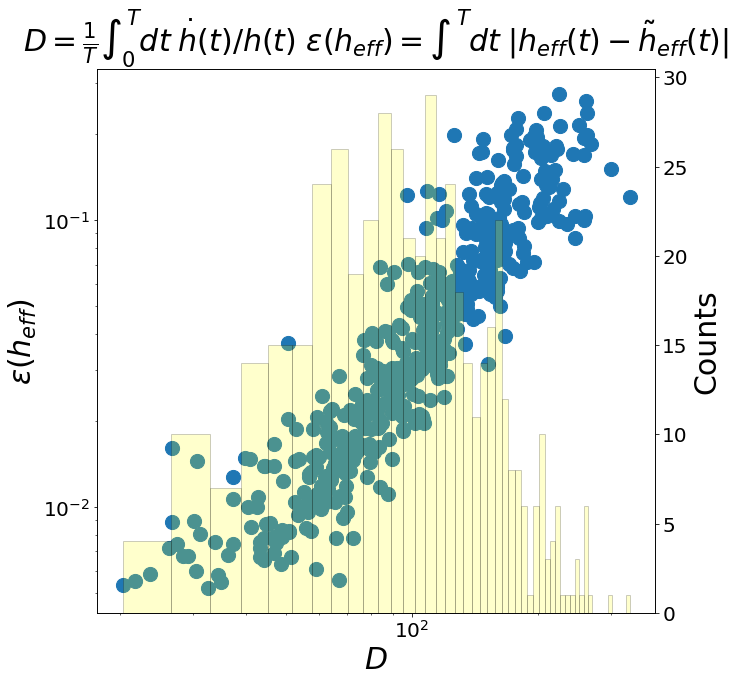

[133.8506202  129.58940134 152.9125904   59.1417686  177.24452921
  91.0079376   86.31177997  83.32869915  96.95451943 158.10328473
 138.56721378 119.39048752  81.18839796 170.24697478  82.41268917
 155.56990938 153.82012943 118.80224884 224.5339076   46.83276022
 152.09427979  95.78566153 102.72004468 204.05530968  81.10291545
  70.02201097  65.51951034 245.52645962  66.90313771  40.44367047
  64.52326328 149.22302121 102.9750033  159.6593344   83.17291188
  79.27416698 196.24395684  83.81596582 101.29981512 166.02675334
 116.00144653 128.14933146  69.18096346 103.35852439 243.50376317
  75.59723367  95.61459757  88.05908571 159.82575213  77.98605453
  70.35324192  95.07543251 165.90865251 125.81511498 107.80770308
  62.96229818  91.77861844 127.84113217 166.26674968  53.9552153
  26.68136557  97.38923516  82.34458862  91.88919014  48.66948932
  98.88574106  48.89707088  78.03885688  62.27710748 120.61140003
  76.19403209  52.6206505  147.50163662  50.82285584 145.33310734
  33.859713

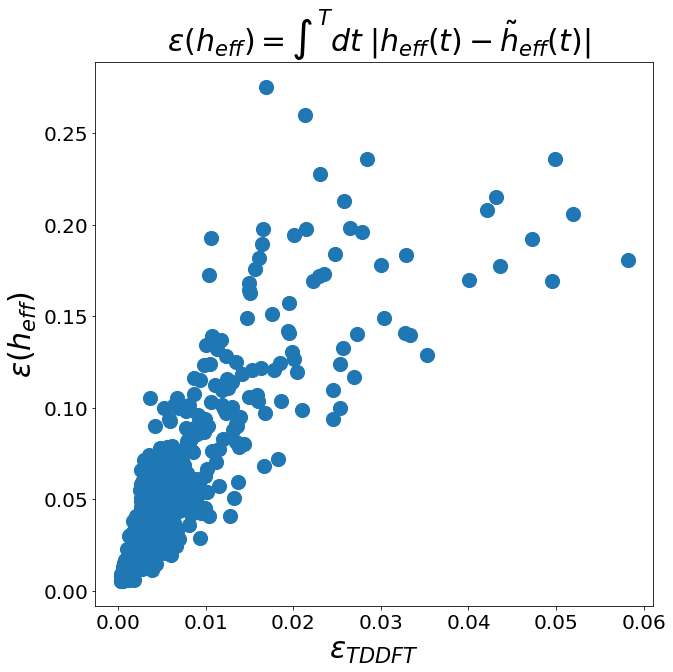

In [100]:

# correlator

idx=np.random.randint(0,50)
h_study=h[:,1:,:]
t=np.arange(time.shape[0]//2)
tau=np.arange(time.shape[0]//2)

matrix_correlator=np.zeros((h_study.shape[0],time.shape[0]//2,time.shape[0]//2))

matrix_correlator=h_study[:,t[:,None],0]*h_study[:,t[:,None]+tau[None,:],0]

correlator=np.average(matrix_correlator,axis=1)

normalized_correlator=correlator/correlator[:,0,None]
print(normalized_correlator.shape)
plt.plot(time[:time.shape[0]//2],normalized_correlator[idx])
plt.show()

plt.plot(time[:500],h_study[idx,:500,0])
plt.show()

average_normalized_correlator=np.average(normalized_correlator,axis=-1)

plt.hist(average_normalized_correlator,bins=30)
plt.show()

plt.scatter(average_normalized_correlator,prediction_errors[-1])
plt.show()

# standard deviation

zero_mean_h_study=h_study-np.average(h_study,axis=1)[:,None,:]
std_h_study=np.std(zero_mean_h_study,axis=1)[:,0]


# speed
print(h_study.shape)
current_h_study=np.gradient(h_study,time,axis=1)
speed=np.average(current_h_study/(h_study+10**-5),axis=1)[:,0]




print(speed)
fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
ax.scatter(speed,prediction_errors[0],s=200)
ax.set_xlabel(r'$D$',fontsize=30)
ax.set_ylabel(r'$\epsilon(h_{eff})$',fontsize=30)
plt.title(r'$D=\frac{1}{T}\int^{T}_0 d t \; \dot{h}(t)/h(t)$ $\epsilon(h_{eff})=\int^T d t \; |h_{eff}(t)-\tilde{h}_{eff}(t)|$',fontsize=30)
ax.tick_params(which='major',labelsize=20)
ax_twin.tick_params(which='major',labelsize=20)
ax_twin.hist(speed,bins=50,edgecolor='black', alpha=0.2,color='yellow')
ax_twin.set_ylabel('Counts',fontsize=30)
ax.loglog()
plt.show()


print(speed)
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(dz_average_time,prediction_errors[0],s=200)
ax.set_xlabel(r'$\epsilon_{TDDFT}$',fontsize=30)
ax.set_ylabel(r'$\epsilon(h_{eff})$',fontsize=30)
plt.title(r' $\epsilon(h_{eff})=\int^T d t \; |h_{eff}(t)-\tilde{h}_{eff}(t)|$',fontsize=30)
ax.tick_params(which='major',labelsize=20)
plt.show()




#### More effective field samples

In [ ]:
#index_sample=np.random.randint(0,maxdata)


# for idx in range(h_eff.shape[-1]):
for i,h_eff_prediction in enumerate(hs_predictions):
    plt.figure(figsize=(10,10))
    plt.plot(time,h_eff_prediction[idx,1:,:2],linestyle='--',linewidth=5,label=labels[i])
    plt.plot(time,h_eff[idx,1 :, :2],color='black',linewidth=2)
    plt.ylabel(r'$h_{eff}(t)$',fontsize=40)
    plt.xlabel(r'$t[1/J]$',fontsize=40)
    #plt.axvline(x=20,color='green',linestyle='--',linewidth=5)
    #plt.legend(fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
    plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
    plt.savefig('effective_field_predictions')
    #plt.fill_between(time[:200], -4.6,-2.1, color='gold', alpha=0.3)
    #plt.ylim([-4.6,-2.1])
    #plt.xlim([0,40])
    plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [ ]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip
import numpy as np
from scipy.integrate import solve_ivp

class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [101]:
from scipy.interpolate import interp1d
# build up the operators
x_op=np.array([[0.,1.],[1.,0]],dtype=np.complex128)
z_op=np.array([[1.,0.],[0.,-1.]],dtype=np.complex128)

# maybe there is a problem with the time step
old_steps=200

old_time=np.linspace(0,20,old_steps)


maxdata=20
nsteps=2000

tf=20.
l=8
j=-1. 
omega=1.
time = np.linspace(0.0, tf,nsteps)
dt=time[1]-time[0]



p=np.random.randint(0,maxdata)

zs_prediction=[] #list for the predictions
for r,h_eff_prediction in enumerate(hs_predictions):
    print(r)
    #slot for the prediction
    z_prediction=np.zeros((maxdata,old_steps,l))
    
    # initialize the effective field with the interpolation
    # to more dense grids
    print(h_eff_prediction.shape)
    old_h_eff=h_eff_prediction[:,1:].copy()
    f=interp1d(old_time,old_h_eff,axis=1)
    h_eff_operation=f(time)
    
    print(h_eff_operation.shape)

    for a in trange(maxdata):
        psi=np.zeros((2,l))
        psi[0] = np.sqrt((1 + z[a,0]) / 2)
        psi[1] = np.sqrt((1 - z[a,0]) / 2)
        h_eff_sample=h_eff_operation[a]
        print(h_eff_sample.shape)
        z_reconstruction=np.zeros((nsteps,l))
        for i in range(nsteps):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi),x_op,psi)
            #pbc
            nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            
            #obc
            # shift_plus=np.zeros(l)
            # shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
            
            
            # shift_minus=np.zeros(l)
            # shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
            # nonlinear_term=j*(shift_plus+shift_minus)+omega
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff_sample[i,0,None,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi=np.einsum('lab,bl->al',exp_h_t,psi)
            psi=psi/np.linalg.norm(psi,axis=0)
            
            z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
            
        z_prediction[a]=np.array([np.interp(old_time, time, z_reconstruction[:, i]) for i in range(z_reconstruction.shape[1])]).T
    
    zs_prediction.append(z_prediction)
        

0
(500, 201, 1)
(500, 2000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(2000, 1)


/tmp/ipykernel_352456/2146771655.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)


  5%|▌         | 1/20 [00:04<01:17,  4.08s/it]

(2000, 1)


 10%|█         | 2/20 [00:10<01:37,  5.43s/it]

(2000, 1)


 15%|█▌        | 3/20 [00:16<01:33,  5.51s/it]

(2000, 1)


 20%|██        | 4/20 [00:21<01:28,  5.51s/it]

(2000, 1)


 25%|██▌       | 5/20 [00:28<01:28,  5.88s/it]

(2000, 1)


 30%|███       | 6/20 [00:32<01:13,  5.25s/it]

(2000, 1)


 35%|███▌      | 7/20 [00:36<01:02,  4.82s/it]

(2000, 1)


 40%|████      | 8/20 [00:40<00:54,  4.55s/it]

(2000, 1)


 45%|████▌     | 9/20 [00:44<00:48,  4.40s/it]

(2000, 1)


 50%|█████     | 10/20 [00:48<00:43,  4.32s/it]

(2000, 1)


 55%|█████▌    | 11/20 [00:53<00:40,  4.47s/it]

(2000, 1)


 60%|██████    | 12/20 [00:58<00:37,  4.70s/it]

(2000, 1)


 65%|██████▌   | 13/20 [01:03<00:34,  4.93s/it]

(2000, 1)


 70%|███████   | 14/20 [01:08<00:28,  4.82s/it]

(2000, 1)


 75%|███████▌  | 15/20 [01:13<00:24,  4.95s/it]

(2000, 1)


 80%|████████  | 16/20 [01:19<00:20,  5.13s/it]

(2000, 1)


 85%|████████▌ | 17/20 [01:24<00:15,  5.26s/it]

(2000, 1)


 90%|█████████ | 18/20 [01:30<00:10,  5.29s/it]

(2000, 1)


 95%|█████████▌| 19/20 [01:34<00:05,  5.06s/it]

(2000, 1)


100%|██████████| 20/20 [01:38<00:00,  4.90s/it]


1
(500, 201, 1)
(500, 2000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(2000, 1)


  5%|▌         | 1/20 [00:04<01:17,  4.06s/it]

(2000, 1)


 10%|█         | 2/20 [00:08<01:14,  4.13s/it]

(2000, 1)


 15%|█▌        | 3/20 [00:11<01:04,  3.77s/it]

(2000, 1)


 20%|██        | 4/20 [00:14<00:55,  3.49s/it]

(2000, 1)


 25%|██▌       | 5/20 [00:17<00:50,  3.35s/it]

(2000, 1)


 30%|███       | 6/20 [00:22<00:53,  3.85s/it]

(2000, 1)


 35%|███▌      | 7/20 [00:26<00:51,  3.96s/it]

(2000, 1)


 40%|████      | 8/20 [00:30<00:45,  3.77s/it]

(2000, 1)


 45%|████▌     | 9/20 [00:34<00:43,  3.99s/it]

(2000, 1)


 50%|█████     | 10/20 [00:37<00:37,  3.78s/it]

(2000, 1)


 55%|█████▌    | 11/20 [00:41<00:32,  3.62s/it]

(2000, 1)


 60%|██████    | 12/20 [00:46<00:32,  4.08s/it]

(2000, 1)


 65%|██████▌   | 13/20 [00:51<00:31,  4.50s/it]

(2000, 1)


 70%|███████   | 14/20 [00:57<00:28,  4.76s/it]

(2000, 1)


 75%|███████▌  | 15/20 [01:03<00:25,  5.13s/it]

(2000, 1)


 80%|████████  | 16/20 [01:08<00:21,  5.30s/it]

(2000, 1)


 85%|████████▌ | 17/20 [01:14<00:16,  5.49s/it]

(2000, 1)


 90%|█████████ | 18/20 [01:19<00:10,  5.35s/it]

(2000, 1)


 95%|█████████▌| 19/20 [01:26<00:05,  5.90s/it]

(2000, 1)


100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


2
(500, 201, 1)
(500, 2000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(2000, 1)


  5%|▌         | 1/20 [00:05<01:35,  5.02s/it]

(2000, 1)


 10%|█         | 2/20 [00:10<01:36,  5.35s/it]

(2000, 1)


 15%|█▌        | 3/20 [00:15<01:29,  5.26s/it]

(2000, 1)


 20%|██        | 4/20 [00:20<01:23,  5.21s/it]

(2000, 1)


 25%|██▌       | 5/20 [00:25<01:16,  5.11s/it]

(2000, 1)


 30%|███       | 6/20 [00:31<01:12,  5.15s/it]

(2000, 1)


 35%|███▌      | 7/20 [00:37<01:14,  5.74s/it]

(2000, 1)


 40%|████      | 8/20 [00:43<01:08,  5.74s/it]

(2000, 1)


 45%|████▌     | 9/20 [00:49<01:02,  5.64s/it]

(2000, 1)


 50%|█████     | 10/20 [00:54<00:55,  5.57s/it]

(2000, 1)


 55%|█████▌    | 11/20 [00:59<00:49,  5.49s/it]

(2000, 1)


 60%|██████    | 12/20 [01:05<00:44,  5.59s/it]

(2000, 1)


 65%|██████▌   | 13/20 [01:10<00:37,  5.40s/it]

(2000, 1)


 70%|███████   | 14/20 [01:15<00:31,  5.17s/it]

(2000, 1)


 75%|███████▌  | 15/20 [01:19<00:24,  4.85s/it]

(2000, 1)


 80%|████████  | 16/20 [01:24<00:20,  5.07s/it]

(2000, 1)


 85%|████████▌ | 17/20 [01:29<00:14,  4.85s/it]

(2000, 1)


 90%|█████████ | 18/20 [01:33<00:09,  4.62s/it]

(2000, 1)


 95%|█████████▌| 19/20 [01:38<00:04,  4.69s/it]

(2000, 1)


100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


3
(500, 201, 1)
(500, 2000, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(2000, 1)


  5%|▌         | 1/20 [00:03<01:14,  3.90s/it]

(2000, 1)


 10%|█         | 2/20 [00:07<01:06,  3.67s/it]

(2000, 1)


 15%|█▌        | 3/20 [00:11<01:01,  3.64s/it]

(2000, 1)


 20%|██        | 4/20 [00:15<01:04,  4.06s/it]

(2000, 1)


 25%|██▌       | 5/20 [00:19<01:00,  4.00s/it]

(2000, 1)


 30%|███       | 6/20 [00:23<00:54,  3.88s/it]

(2000, 1)


 35%|███▌      | 7/20 [00:28<00:55,  4.25s/it]

(2000, 1)


 40%|████      | 8/20 [00:33<00:55,  4.62s/it]

(2000, 1)


 45%|████▌     | 9/20 [00:39<00:53,  4.86s/it]

(2000, 1)


 50%|█████     | 10/20 [00:43<00:46,  4.64s/it]

(2000, 1)


 55%|█████▌    | 11/20 [00:47<00:40,  4.55s/it]

(2000, 1)


 60%|██████    | 12/20 [00:52<00:38,  4.76s/it]

(2000, 1)


 65%|██████▌   | 13/20 [00:58<00:34,  4.97s/it]

(2000, 1)


 70%|███████   | 14/20 [01:03<00:30,  5.03s/it]

(2000, 1)


 75%|███████▌  | 15/20 [01:09<00:26,  5.33s/it]

(2000, 1)


 80%|████████  | 16/20 [01:15<00:21,  5.48s/it]

(2000, 1)


 85%|████████▌ | 17/20 [01:20<00:16,  5.34s/it]

(2000, 1)


 90%|█████████ | 18/20 [01:24<00:10,  5.03s/it]

(2000, 1)


 95%|█████████▌| 19/20 [01:30<00:05,  5.22s/it]

(2000, 1)


100%|██████████| 20/20 [01:36<00:00,  4.80s/it]


 PBC

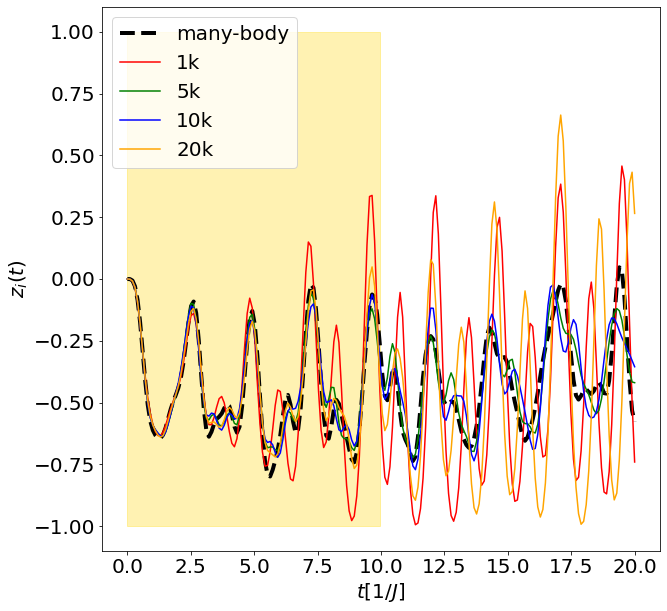

In [120]:
idx=np.random.randint(0,maxdata)
idx=15
fig,ax=plt.subplots(figsize=(10,10))
r=0

ax.plot(old_time,z[idx,:,r],color='black',label='many-body',linestyle='--',linewidth=4)
ax.plot(old_time,zs_prediction[0][idx,:,r],color='red',label='1k')
ax.plot(old_time,zs_prediction[1][idx,:,r],color='green',label='5k')
ax.plot(old_time,zs_prediction[2][idx,:,r],color='blue',label='10k')
ax.plot(old_time,zs_prediction[3][idx,:,r],color='orange',label='20k')

if i==0 and j==0:
    ax.legend(fontsize=30)
ax.set_ylabel(r'$z_i(t)$',fontsize=20)
ax.set_xlabel(r'$t[1/J]$',fontsize=20)
ax.tick_params(which='major',labelsize=20)
ax.fill_between(old_time[:100], -1,1, color='gold', alpha=0.3)
#ax.set_ylim([-1,0])

plt.legend(fontsize=20)
plt.savefig('images/magnetization_results_obc_training_driving')
#plt.xlim([0,0.01])
plt.show()

In [ ]:
idx=np.random.randint(0,maxdata)
fig,ax=plt.subplots(4,2,figsize=(17,20))

for i in range(4):
    for j in range(2):
        r=(i)+4*j
        ax[i,j].plot(old_time,z[idx,:,r],color='black',label='many-body')
        #ax[i,j].plot(old_time,zs_prediction[0][idx,:,r],color='red',linestyle='--',label='auxiliary')
        #ax[i,j].plot(old_time,zs_prediction[1][idx,:,r],color='green',linestyle='--',label='auxiliary')
        ax[i,j].plot(old_time,zs_prediction[2][idx,:,r],color='blue',linestyle='--',label='auxiliary')
        if i==0 and j==0:
            ax[i,j].legend(fontsize=30)
        ax[i,j].set_ylabel(r'$z_i(t)$',fontsize=20)
        ax[i,j].set_xlabel(r'$t[1/J]$',fontsize=20)
        ax[i,j].tick_params(which='major',labelsize=20)
        ax[i,j].fill_between(old_time[:100], -1,1, color='gold', alpha=0.3)
        #ax[i,j].set_ylim([-1,-0.7])
        #ax[i,j].set_xlim([0,40])
        
plt.savefig('images/magnetization_results_obc_training_driving')
#plt.xlim([0,0.01])
plt.show()


(50, 1000, 1)
(20, 1000, 8)
(1000,)
(1000,)
(1000,)


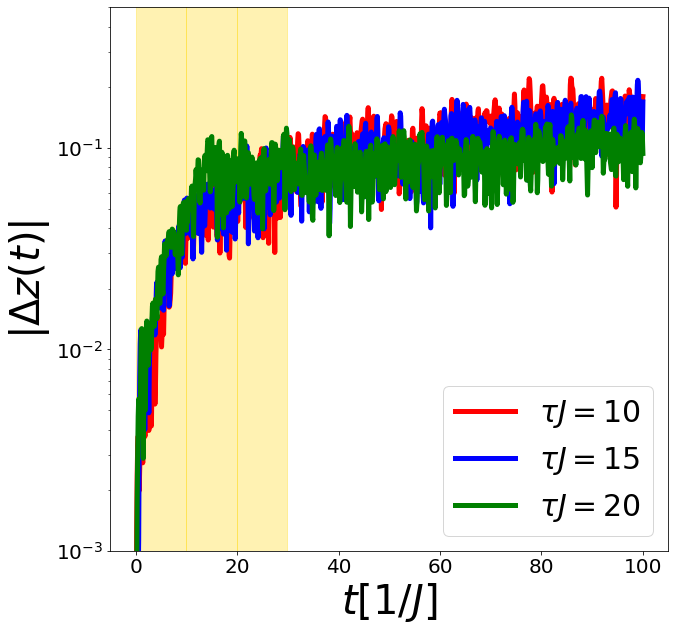

In [ ]:
print(z.shape)
print(z_prediction.shape)
plt.figure(figsize=(10,10))
for i in range(3):
    dz=np.average(np.average(np.abs(zs_prediction[i]-z[:maxdata,:,:]),axis=-1),axis=0)

    print(dz.shape)
    
    q=0
    plt.plot(old_time,dz,linewidth=5,color=colors[i],label=labels[i])
plt.fill_between(old_time[:100], 0,1, color='gold', alpha=0.3)
plt.fill_between(old_time[100:200], 0,1, color='gold', alpha=0.3)
plt.fill_between(old_time[200:300], 0,1, color='gold', alpha=0.3)

plt.semilogy()
plt.legend(fontsize=30)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z (t)|$',fontsize=40)
plt.ylim([10**-3,0.5])
plt.tick_params(which='major',labelsize=20)
plt.savefig('images/magnetization_error_obc_training_driving')
plt.show()

#### Test a different field

#### Compute the Hamiltonian

In [ ]:
class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

nbatch = 1

l = 8
# rates = [0.1, 0.5, 0.8, 1.0]

# j coupling
j = 1
# omega auxiliary field
maxdata=1
omega = 1
maxdata=1
rate_max=1.
rate_min=0.1

amplitude_max=1
amplitude_min=0.1

steps = 600
tf = 60.0
time = np.linspace(0.0, tf, steps)
gamma=1

ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=False,
    coupling_values=[j],
    size=l,
)

hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

obs: List[qutip.Qobj] = []
current_obs: List[qutip.Qobj] = []

for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    #pbc
    # current = SpinOperator(
    #     index=[("x", (i - 1) % l, "y", i), ("y", i, "x", (i + 1) % l)],
    #     coupling=[2 * j, 2 * j],
    #     size=l,
    # )
    #obc
    print(l)
    # if i-1 >=0 and i+1<=l-1:
    #     current = SpinOperator(
    #         index=[("x", (i - 1) , "y", i), ("y", i, "x", (i + 1) )],
    #         coupling=[2 * j, 2 * j],
    #         size=l,
    #     )

    obs.append(z_op.qutip_op)
    # current_obs.append(current.qutip_op)

heffs=np.zeros((maxdata,steps,l))
hs=np.zeros_like(heffs)
z=np.zeros((maxdata,steps,l))    


for a in trange(maxdata):
    final_value=1
    initial_value=2
    hf=final_value*np.ones((time.shape[0], l))
    hi=initial_value*np.ones((time.shape[0], l))

    # rate = np.random.uniform(0.3, 1.0)

    rate_cutoff = 15
    rate=np.random.uniform(rate_min,rate_max,size=rate_cutoff)
    delta = np.random.uniform(amplitude_min,amplitude_max,size=(rate_cutoff))

    h = (
        delta[:, None, None]
        * np.sin(time[None, :, None] * rate[:, None, None])
        + hi
    )

    #h=np.exp(-time*gamma)[:,None]*hi[None,:]+(1-np.exp(-time*gamma)[:,None])*hf[None,:]
    #h=h[0]

    h = np.average(h, axis=0)
    print(h.shape)
    h=hi*np.exp(-time*gamma)[:,None]+(1-np.exp(-time*gamma)[:,None])*hf[None,:]

    h=h[0]
    
    plt.figure(figsize=(10,10))
    plt.plot(time,h,color='black',linewidth=3)
    plt.xlabel(r'$t[1/J]$',fontsize=40)
    plt.ylabel(r'$h(t)$',fontsize=40)
    plt.tick_params(which='major',labelsize=30)
    plt.savefig(f'images/quench_driving_gamma_{gamma:.0f}')
    plt.show()
    print(h.shape)
    hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

    eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
        eigvals=1
    )
    psi0 = psi0[
        0
    ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))

    print("real ground state energy=", eng[0])

    hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

    for i in range(l):
        drive_z = Driving(
            h=h,
            dt=time[1] - time[0],
            idx=i,
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution and

    output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs)

    current_exp = np.zeros((steps, l))
    z_exp = np.zeros_like(current_exp)

    for r in range(l):
        z_exp[:, r] = output.expect[r]
        

    # Current derivative
    current_exp=np.gradient(z_exp, time, axis=0)
    current_derivative = np.gradient(current_exp, time, axis=0)

    # compute the effective field
    x_sp = np.sqrt(1 - z_exp**2) * np.cos(
        np.arcsin(-1 * (current_exp) / (2 * np.sqrt(1 - z_exp**2)))
    )


    current_derivative = np.gradient(current_exp, time, axis=0)
    #plt.plot(current_derivative)
    #pbc
    # nonlinear_term=j*(np.roll(x_sp,shift=1,axis=-1)+np.roll(x_sp,shift=-1,axis=-1))
    # plt.plot(nonlinear_term)
    # part_1=0.25*current_derivative/(nonlinear_term+omega)
    # part_2=(nonlinear_term+omega)*z_exp
    # h_eff = (part_1 + part_2) / (x_sp + 10**-4)

    #obc
    shift_plus=np.zeros((time.shape[0],l))
    shift_plus[:,1:]=x_sp[:,1:] #np.roll(x_sp,shift=1,axis=-1)
    shift_minus=np.zeros((time.shape[0],l))
    shift_minus[:,:-1]=x_sp[:,:-1] #np.roll(x_sp,shift=-1,axis=-1)
    nonlinear_term=j*(shift_plus+shift_minus)
    part_1=0.25*current_derivative/(nonlinear_term+omega)
    part_2=(nonlinear_term+omega)*z_exp
    h_eff = (part_1 + part_2) / (x_sp + 10**-20)
    
    heffs[a]=h_eff
    hs[a]=h
    z[a]=z_exp


In [ ]:
print(h.shape)
print(h_eff.shape)
print(z.shape,hs.shape)
input=np.append(z[:,0].reshape(-1,1,l),hs,axis=1)


heff_prediction,_=model(torch.from_numpy(input))
heff_prediction=heff_prediction.detach().numpy()
print(heff_prediction.shape)
plt.plot(time,heff_prediction[0,1:],color='red',linestyle='--')
plt.plot(time,heffs[0,:],color='black',linestyle='-')
plt.show()


p=np.random.randint(0,maxdata)

plt.figure(figsize=(10,10))
plt.plot(time,hs[p],color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,heff_prediction[p,1:],color='red',linestyle='--',linewidth=4,)
plt.plot(time,heffs[p],color='black',linewidth=4,)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h_{eff,i}(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.title('red line prediction, black line exact',fontsize=30)
plt.savefig(f'images/periodic_effective_field_gamma_{gamma:.0f}')
plt.show()


dheff=np.average(np.abs(heff_prediction[:,1:]-heffs),axis=(0,-1))

plt.figure(figsize=(10,10))
plt.plot(time,dheff,color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta h_{eff}(t)|$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.show()


In [ ]:
from scipy.interpolate import interp1d
# build up the operators
x_op=np.array([[0.,1.],[1.,0]],dtype=np.complex128)
z_op=np.array([[1.,0.],[0.,-1.]],dtype=np.complex128)


nsteps=600
tf=60.
l=8
j=1. 
omega=1.
time = np.linspace(0.0, tf,nsteps)
dt=time[1]-time[0]

p=np.random.randint(0,maxdata)


z_prediction=np.zeros((maxdata,nsteps,l))

print(hs_predictions[0][p,:2])
for a in trange(maxdata):
    psi=np.zeros((2,l))
    psi[0] = np.sqrt((1 + z[a,0]) / 2)
    psi[1] = np.sqrt((1 - z[a,0]) / 2)
    h_eff_sample=heff_prediction[a,1:]
    z_reconstruction=np.zeros((nsteps,l))
    for i in range(nsteps):
        x_ave=np.einsum('al,ab,bl->l',np.conj(psi),x_op,psi)
        #pbc
        #nonlinear_term=j*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
        
        #obc
        shift_plus=np.zeros(l)
        shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
        shift_minus=np.zeros(l)
        shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
        nonlinear_term=j*(shift_plus+shift_minus)+omega
        hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff_sample[i,:,None,None]*z_op[None,:,:]
        exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
        for r in range(l):
            exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
        #print(exp_h_t)    
        psi=np.einsum('lab,bl->al',exp_h_t,psi)
        psi=psi/np.linalg.norm(psi,axis=0)
        
        z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
    z_prediction[a]=z_reconstruction

In [ ]:
fig,ax=plt.subplots(4,2,figsize=(40,60))
for i in range(4):
    for j in range(2):
        r=(i)+4*(j)
        ax[i,j].plot(time,z_prediction[p,:,r],color='red',linestyle='--',linewidth=5)
        ax[i,j].plot(time,z[p,:,r],color='black',linestyle='-',linewidth=5)
        ax[i,j].tick_params(which='major',labelsize=30)
        ax[i,j].set_xlabel(r'$t[1/J]$',fontsize=40)
        ax[i,j].set_ylabel(r'$z_i(t)$',fontsize=40)
        ax[i,j].set_title(f'i={r}',fontsize=40)
plt.show()

dz=np.average(np.abs(z_prediction-z),axis=(0,-1))
plt.figure(figsize=(10,10))
plt.plot(time,dz,color='black',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z(t)|$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.savefig(f'images/magnetization_results_inverse_quench_gamma_{gamma:.0f}')
plt.show()


In [ ]:
l =1
steps = 400
tf = 40.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)

zs_prediction=[]
for j in range(10):

    for idx in range(l):
        psi0 = np.zeros(2)
        psi0[0] = np.sqrt((1 + zs[j, 0]) / 2)
        psi0[1] = np.sqrt((1 - zs[j, 0]) / 2)
        
        if idx==0:
            psi=psi0
        else:
            psi=np.kron(psi,psi0)
            
    psi0 = qutip.Qobj(
        psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
    )



    # Measure observable
    obs:List=[]
    for i in range(l):
        obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)


    # build up the time dependent object for the qutip evolution
    hamiltonian = [ham0.qutip_op]
    for i in range(l):
        drive_z = Driving(
            h=
                h_eff_prediction[j,1:]
            ,
            idx=i,
            dt=time[1] - time[0],
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution
    output = qutip.sesolve(
        hamiltonian,
        psi0,
        time,
        e_ops=obs
    )

    z_prediction=np.zeros((time.shape[0],l))
    for r in range(l):
        z_prediction[:, r] = output.expect[r]
    
    zs_prediction.append(z_prediction)

zs_prediction=np.asarray(zs_prediction)
    

In [ ]:
print(zs.shape,zs_prediction.shape)
dz=np.average(np.abs(zs_prediction[:,:,0]-zs[:,:]),axis=0)

plt.plot(time,dz)
plt.xlabel(r'$t [1/J]$',fontsize=30)
plt.ylabel(r'$|\Delta z (t)|$',fontsize=40)

plt.show()


for i in range(10):
    
    plt.plot(time,zs[i])
    plt.plot(time,zs_prediction[i])
    plt.show()

In [ ]:
plt.plot(time,z_exp)
plt.plot(time,z_prediction)
plt.show()

## DL-effective field and computation via auxiliary system (LSTM)

#### Imports

In [ ]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import field2field_mapping

torch.set_num_threads(3)

#### Data

In [ ]:
data = np.load(
    "data/dataset_h_eff/xxzx_model/dataset_2024-07-14_00-36_LSTM_notime_bis.npz"
)

maxdata=100

h = data["h"][-maxdata:]
h_eff = data["h_eff"][-maxdata:]
z=data['z'][-maxdata:]
time=data['time']
#ls=data['l']

models=[]

labels=[r'$\tau=20 [1/J]$']
models_name=['LSTM_field2field_xxzx_nonlinear_auxiliary_field_omega_01-10_time_steps_200_tf_40_240715_dataset_50k_[800, 800, 800, 800]_hc_[0]_ks_0_ps_4_nconv_1_nblock']
#models_name=['LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240625_dataset_20k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240628_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_200_tf_40_240629_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock']
for i,name in enumerate(models_name):
    model = torch.load(
    "model_rep/lstm_field2field/"+name,
    map_location="cpu",
    )
    model.eval()
    models.append(model)

# Loading the model


#### Structure of the Driving

In [ ]:
index_sample= np.random.randint(0,maxdata)

plt.figure(figsize=(10,10))
plt.plot(time,h[index_sample,1:,0],color='black',linewidth=3)
plt.xlabel(r'$t [1/J]$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.savefig('images/driving_training_pbc')
plt.show()

#### $h_{eff}(t)$ from the DL mapping

In [ ]:
hs_predictions=[]
for model in models:

    h_eff_prediction,_=model(torch.tensor(h))
    h_eff_prediction = h_eff_prediction.detach().numpy()
    # h_eff_prediction=np.einsum('bit->bti',h_eff_prediction)
    print(h_eff_prediction.shape)
    hs_predictions.append(h_eff_prediction)    

#### Errors

In [ ]:
plt.figure(figsize=(10,10))
print(h_eff_prediction[:10,:3],'\n')
print(h_eff[:10,:3])


dh_eff=np.average(np.average(np.abs(h_eff_prediction[:,1:]-h_eff[:,1:]),axis=-1)/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)


print(dh_eff.shape)

plt.plot(time,dh_eff,linewidth=5,label=labels[i])
plt.tick_params(which='major',labelsize=20,length=3,width=3)
plt.tick_params(which='minor',labelsize=20,length=4,width=2)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta h_{eff}(t)|$',fontsize=40)
plt.legend(fontsize=20)
plt.semilogy()
plt.savefig('images/error_effective_driving_pbc_training')
plt.show()


#### Check the comparison with the exact $h_{eff}(t)$

In [ ]:
#index_sample=np.random.randint(0,maxdata)

# for idx in range(h_eff.shape[-1]):
for i,h_eff_prediction in enumerate(hs_predictions):
    plt.figure(figsize=(10,10))
    plt.plot(time,h_eff_prediction[index_sample,1:,:],linestyle='--',linewidth=5,label=labels[i]+' prediction')
    plt.plot(time,h_eff[index_sample,1 :, 0],color='black',linewidth=2,label='exact')
    plt.ylabel(r'$h_{eff}(t)$',fontsize=40)
    plt.xlabel(r'$t[1/J]$',fontsize=40)
    #plt.axvline(x=20,color='green',linestyle='--',linewidth=5)
    plt.legend(fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
    plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
    plt.fill_between(time[:200], -0.5,-3.1, color='gray', alpha=0.6)
    plt.ylim([-3.1,-.5])
    plt.xlim([0,40])
    plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [ ]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip
from scipy.sparse.linalg import eigsh,expm


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [ ]:
from scipy.interpolate import interp1d
# build up the operators
x_op=np.array([[0.,1.],[1.,0]])
z_op=np.array([[1.,0.],[0.,-1.]])


nsteps=400
tf=40.
dt=tf/nsteps
#l=8
j=1. 
omega=1.
time = np.linspace(0.0, tf, nsteps)

z_prediction=np.zeros((3,maxdata,nsteps,1))
for q in range(1):
    for p in trange(maxdata):

        h_eff_t=hs_predictions[q][p,1:,0]
        l=8#int(ls[p])

        h_new_field=np.ones(l)[None,:]*h_eff_t[:,None]
        psi=np.zeros((2,l))
        psi[0] = np.sqrt((1 + z[p,0,0]) / 2)
        psi[1] = np.sqrt((1 - z[p,0,0]) / 2)

        z_reconstruction=np.zeros((nsteps,l))
        z_reconstruction[0]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
        for i in range(1,nsteps):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi),x_op,psi)
            nonlinear_term=j*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_new_field[i,:,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi=np.einsum('lab,bl->al',exp_h_t,psi)
            psi=psi/np.linalg.norm(psi,axis=0)
            
            z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
            
        # # plt.plot(time,z[p])
        # # plt.plot(time,z_reconstruction,color='red')
        # # plt.show()
        z_prediction[q,p,:,0]=z_reconstruction[:,0]

    # plt.plot(time,h_new_field)
    # plt.plot(time,h_eff[p,1:])
    # plt.show()

In [ ]:
dz=np.average(np.abs(z_prediction-z[None,:,:,:]),axis=-1)/np.average(np.abs(z[:,:,:]),axis=-1)
dz=np.average(dz,axis=1)
print(dz.shape)
plt.figure(figsize=(10,10))
q=0
plt.plot(time[1:],dz[q,1:],linewidth=5,label=labels[q])
plt.semilogy()
plt.legend(fontsize=30)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z (t)|$',fontsize=40)
plt.tick_params(which='major',labelsize=20)
plt.savefig('images/error_magnetization_pbc_training')
plt.show()

In [ ]:
#p=np.random.randint(maxdata)
plt.figure(figsize=(10,10))
plt.plot(time,z[index_sample,:,0],linewidth=4,color='black',label='exact')
for q in range(1):
    plt.plot(time,z_prediction[q,index_sample,:,0],label=labels[-1]+' auxiliary',linestyle='--',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$z(t)$',fontsize=40)
plt.legend(fontsize=20)
plt.tick_params(which='major',labelsize=20)
plt.savefig('images/magnetization_pbc_training_driving')
plt.fill_between(time[:200], -1,0, color='gray', alpha=0.6)
plt.ylim([-1,0])
plt.xlim([0,40])
plt.show()
plt.show()

#### Different scale

In [ ]:

# hyperparameters

nbatch = 1

batch_size = 50
l =10
# rates = [0.1, 0.5, 0.8, 1.0]

# j coupling
j = 1
# omega auxiliary field
omega = 1

rate_max=1.5
rate_min=0.1

amplitude_max=1.0
amplitude_min=0.1

steps = 400
tf = 40.0
time = np.linspace(0.0, tf, steps)

info=f'xx-z-x model with omega={omega:.1f}, coupling={j: .1f} external field with rate max={rate_max:.1f} and rate min={rate_min:.1f} amplitude max={amplitude_max:.1f} amplitude min={amplitude_min:.1f} tf={tf:.0f} steps={steps} l={l} ndata={batch_size}'
comments='different initial state, magnetization per site and non-linear auxiliary field'
# z_qutip_tot = np.zeros((nbatch * nbatch * batch_size, steps, l))
z_qutip_tot = np.zeros(( batch_size , steps, l))
z_qutip_tot_global = np.zeros(( batch_size , steps, 1))
h_eff_tot = np.zeros(( batch_size , steps, l))
h_tot = np.zeros(( batch_size , steps, l))
current_qutip_tot = np.zeros(( batch_size , steps, l))
current_derivative_tot = np.zeros(( batch_size , steps, l))
x_sp_tot = np.zeros(( batch_size , steps, l))

ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=True,
    coupling_values=[j],
    size=l,
)

hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

obs: List[qutip.Qobj] = []
current_obs: List[qutip.Qobj] = []

for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    current = SpinOperator(
        index=[("x", (i - 1) % l, "y", i), ("y", i, "x", (i + 1) % l)],
        coupling=[2 * j, 2 * j],
        size=l,
    )

    obs.append(z_op.qutip_op)
    current_obs.append(current.qutip_op)

#hi = np.ones((time.shape[0], l))  # we fix the initial field to be 1J

for idx in trange(0, batch_size):
    
    
    initial_value=1.2#np.random.uniform(0.5,1.5)
    hi=initial_value*np.ones((time.shape[0], l))

    # rate = np.random.uniform(0.3, 1.0)

    rate_cutoff = 15
    rate=np.random.uniform(rate_min,rate_max,size=rate_cutoff)
    delta = np.random.uniform(amplitude_min,amplitude_max,size=(rate_cutoff))
    
    h = (
        delta[:, None, None]
        * np.sin(time[None, :, None] * rate[:, None, None])
        + hi
    )
    
    gamma=2.
    
    #h=hi[None,:]*np.exp(-time*gamma)[:,None]+(1-np.exp(-time*gamma)[:,None])*0.6

    h = np.average(h, axis=0)
    print('hshape=',h.shape)
    #gamma=10.
    #h=1.5*np.ones(l)*(np.exp(-time*gamma))[:,None]+0.5-np.exp(-time*gamma)[:,None]
    print('hshape=',h.shape)
    hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

    eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
        eigvals=1
    )
    psi0 = psi0[
        0
    ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))

    print("real ground state energy=", eng[0])

    hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

    for i in range(l):
        drive_z = Driving(
            h=h,
            dt=time[1] - time[0],
            idx=i,
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution and

    output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs + current_obs)

    current_exp = np.zeros((steps, l))
    z_exp = np.zeros_like(current_exp)

    for r in range(l):
        z_exp[:, r] = output.expect[r]
        current_exp[:, r] = output.expect[l + r]

    # Current derivative
    current_derivative = np.gradient(current_exp, time, axis=0)

    # compute the effective field
    x_sp = np.sqrt(1 - z_exp**2) * np.cos(
        np.arcsin(-1 * (current_exp) / (2 * np.sqrt(1 - z_exp**2)))
    )

    


    current_derivative = np.gradient(current_exp, time, axis=0)
    #plt.plot(current_derivative)
    nonlinear_term=j*(np.roll(x_sp,shift=1,axis=-1)+np.roll(x_sp,shift=-1,axis=-1))
    part_1=0.25*current_derivative/(nonlinear_term+omega)
    part_2=(nonlinear_term+omega)*z_exp
    h_eff = (part_1 + part_2) / (x_sp + 10**-20)

    # update the database
    h_eff_tot[idx]=h_eff
    h_tot[idx]=h
    z_qutip_tot[idx]=z_exp
    z_qutip_tot_global[idx,:,0]=np.sum(z_exp,axis=-1)
    current_qutip_tot[idx]=current_exp
    x_sp_tot[idx]=x_sp
    current_derivative_tot[idx]=current_derivative

In [ ]:
plt.plot(time,h_tot[0,:,0])
plt.show()

In [ ]:
maxdata=1

inputs=np.zeros((maxdata,steps+1,1))
inputs[:,0,0]=z_qutip_tot[:,0,0]
print(z_qutip_tot_global[:,0,0])
inputs[:,1:,0]=h_tot[:,:,0]


In [ ]:
hs_predictions_scale=[]
print(inputs.shape)
for model in models:

    h_eff_prediction,_=model(torch.tensor(inputs[:]))
    h_eff_prediction = h_eff_prediction.detach().numpy()
    # h_eff_prediction=np.einsum('bit->bti',h_eff_prediction)
    print(h_eff_prediction.shape)
    hs_predictions_scale.append(h_eff_prediction)    

In [ ]:
p=np.random.randint(maxdata)

plt.figure(figsize=(10,10))
for q in range(1):
    plt.plot(time,hs_predictions_scale[q][p,1:],label=labels[q],linestyle='--',linewidth=4)
plt.plot(time,h_eff_tot[p,:,0],linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.legend(fontsize=30)
plt.ylabel(r'$h_{eff}(t)$',fontsize=40)
plt.tick_params(which='major',labelsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
for q in range(1):
    dh=np.average(np.average(np.abs(hs_predictions_scale[q][:,1:,]-h_eff_tot[:,:,]),axis=-1)/np.average(np.abs(h_eff_tot[:,:,]),axis=-1),axis=0)
    plt.plot(time,dh,label=labels[q],linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.legend(fontsize=30)
plt.ylabel(r'$|\Delta h_{eff}(t)|$',fontsize=40)
plt.semilogy()
plt.tick_params(which='major',labelsize=20)
plt.savefig('images/effective_driving_scalability_pbc_variable_size_dataset')
plt.show()

##### Test on the auxiliary field

In [ ]:
from scipy.interpolate import interp1d
# build up the operators
x_op=np.array([[0.,1.],[1.,0]])
z_op=np.array([[1.,0.],[0.,-1.]])


nsteps=400
tf=40.
dt=tf/nsteps
j=1. 
omega=1.
time = np.linspace(0.0, tf, nsteps)

z_prediction_scale=np.zeros((3,maxdata,nsteps,l))
for q in range(1):
    for p in trange(maxdata):
        h_eff_t=hs_predictions_scale[q][p,1:,0]


        h_new_field=np.ones(l)[None,:]*h_eff_t[:,None]
        psi=np.zeros((2,l))
        psi[0] = np.sqrt((1 + z_qutip_tot[p,0,0]) / 2)
        psi[1] = np.sqrt((1 - z_qutip_tot[p,0,0]) / 2)

        z_reconstruction=np.zeros((nsteps,l))
        z_reconstruction[0]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
        for i in range(1,nsteps):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi),x_op,psi)
            nonlinear_term=j*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_new_field[i,:,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi=np.einsum('lab,bl->al',exp_h_t,psi)
            psi=psi/np.linalg.norm(psi,axis=0)
            
            z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
            
        # # plt.plot(time,z[p])
        # # plt.plot(time,z_reconstruction,color='red')
        # # plt.show()
        z_prediction_scale[q,p]=z_reconstruction

In [ ]:
p=np.random.randint(20)
p=np.random.randint(maxdata)
plt.figure(figsize=(10,10))
plt.plot(time,z_qutip_tot[p,:,0],linewidth=4,color='red')
for q in range(1):
    plt.plot(time,z_prediction_scale[q,p,:,0],label=labels[q],linestyle='--',linewidth=4)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$z(t)$',fontsize=40)
plt.legend(fontsize=20)
plt.tick_params(which='major',labelsize=20)
plt.show()


plt.figure(figsize=(10,10))
dz=np.average(np.average(np.abs(z_prediction_scale[:,:,:,]-z_qutip_tot[None,:,:,]),axis=-1)/np.average(np.abs(z_qutip_tot[None,:,:,]),axis=-1),axis=1)
print(dz.shape)

plt.plot(time[1:],dz[0,1:,])

plt.xlabel(r'$t [1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z(t)|[l=10]$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.semilogy()
plt.show()

In [ ]:
plt.plot(z[1,:,0])
plt.plot(z_prediction[1,:,0])
plt.show()

plt.figure(figsize=(10,10))
dz=np.average(np.abs(z_prediction-z),axis=0)
print(dz.shape)
plt.plot(time,dz[:,0],linewidth=5)
plt.tick_params(which='major',labelsize=20,length=3,width=3)
plt.tick_params(which='minor',labelsize=20,length=4,width=2)
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$|\Delta z(t)|$',fontsize=40)
plt.legend(fontsize=20)
#plt.semilogy()
plt.show()

#### Predictions

In [ ]:
idx=np.random.randint(0,maxdata)

for i,zs in enumerate(zs_samples):
    plt.figure(figsize=(10,10))
    z_prediction=zs[idx]
    plt.plot(time,z_prediction[:,0],linewidth=5,label=labels[i])
    plt.plot(time,z[idx,:,0],color='black',linewidth=2,label='exact')
    plt.ylabel(r'$z(t)$',fontsize=40)
    plt.xlabel(r'$t[1/J]$',fontsize=40)
    #plt.axvline(x=10,color='green',linestyle='--',linewidth=5)

    plt.legend(fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
    plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
    plt.show()

    plt.plot(time, h[index_sample, 1:, :], color="black", linewidth=5)
    plt.ylabel(r"$h(t)$", fontsize=40)
    plt.xlabel(r"$t[1/J]$", fontsize=40)
    #plt.axvline(x=20, color="green", linestyle="--", linewidth=5)

    plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
    plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
    plt.show()

#### Test a different scales

#### Compute the Hamiltonian

In [ ]:
l = 12
# rates = [0.1, 0.5, 0.8, 1.0]

rate = 1.0
# j coupling
j = 1
# omega auxiliary field
omega = 1


steps = 400
tf = 40.0
time = np.linspace(0.0, tf, steps)



ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=True,
    coupling_values=[j],
    size=l,
)

hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

obs: List[qutip.Qobj] = []
current_obs: List[qutip.Qobj] = []

z_op = SpinOperator(index=[("z", i) for i in range(l)], coupling=[1.0/l]*l, size=l, verbose=1)
# print(f"x[{i}]=", x.qutip_op, "\n")


obs.append(z_op.qutip_op)
    
#hi = np.ones((time.shape[0], l))  # we fix the initial field to be 1J

inputs=[]
zs=[]
for i in trange(10):

    initial_value=np.random.uniform(0.5,1.5)
    hi=initial_value*np.ones((time.shape[0], l))

    # rate = np.random.uniform(0.3, 1.0)

    omega = np.linspace(0, np.pi, time.shape[0] // 4)
    omega_cutoff = 16
    delta = np.random.uniform(-2,2,size=(omega_cutoff))

    h = (
        delta[:, None, None]
        * np.sin(time[None, :, None] * omega[:omega_cutoff, None, None])
        + hi
    )

    h = np.average(h, axis=0)

    hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

    eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
        eigvals=1
    )
    psi0 = psi0[
        0
    ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))

    print("real ground state energy=", eng[0])

    hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]


    drive_z = Driving(
        h=h,
        dt=time[1] - time[0],
        idx=0,
    )

    hamiltonian.append([l*obs[0], drive_z.field])

        # evolution and

    output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs)
    z_exp=output.expect[0]
    input=np.zeros((1,time.shape[0]+1,1))
    input[0,0,0]=z_exp[0]
    input[0,1:,0]=h[:,0]
    zs.append(z_exp)
    inputs.append(input)
    
zs=np.asarray(zs)
inputs=np.asarray(inputs)


In [ ]:
print(inputs.shape)

In [ ]:

plt.plot(time,z_exp)

plt.show()


print(inputs.shape)
print(models[0])
h_eff,_=models[0](torch.from_numpy(inputs[:,0]))
h_eff_prediction=h_eff[:,:,:].detach().numpy()
print(h_eff_prediction.shape)

plt.plot(time,h_eff_prediction[0,1:,0])

In [ ]:
l =1
steps = 400
tf = 40.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)

zs_prediction=[]
for j in range(10):

    for idx in range(l):
        psi0 = np.zeros(2)
        psi0[0] = np.sqrt((1 + zs[j, 0]) / 2)
        psi0[1] = np.sqrt((1 - zs[j, 0]) / 2)
        
        if idx==0:
            psi=psi0
        else:
            psi=np.kron(psi,psi0)
            
    psi0 = qutip.Qobj(
        psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
    )



    # Measure observable
    obs:List=[]
    for i in range(l):
        obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)


    # build up the time dependent object for the qutip evolution
    hamiltonian = [ham0.qutip_op]
    for i in range(l):
        drive_z = Driving(
            h=
                h_eff_prediction[j,1:]
            ,
            idx=i,
            dt=time[1] - time[0],
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution
    output = qutip.sesolve(
        hamiltonian,
        psi0,
        time,
        e_ops=obs
    )

    z_prediction=np.zeros((time.shape[0],l))
    for r in range(l):
        z_prediction[:, r] = output.expect[r]
    
    zs_prediction.append(z_prediction)

zs_prediction=np.asarray(zs_prediction)
    

In [ ]:
print(zs.shape,zs_prediction.shape)
dz=np.average(np.abs(zs_prediction[:,:,0]-zs[:,:]),axis=0)

plt.plot(time,dz)
plt.xlabel(r'$t [1/J]$',fontsize=30)
plt.ylabel(r'$|\Delta z (t)|$',fontsize=40)

plt.show()


for i in range(10):
    
    plt.plot(time,zs[i])
    plt.plot(time,zs_prediction[i])
    plt.show()

In [ ]:
plt.plot(time,z_exp)
plt.plot(time,z_prediction)
plt.show()

## DL-effective field and computation via auxiliary system (Pixel CNN)

#### Imports

In [ ]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import field2field_mapping

#### Data

In [ ]:
data = np.load("data/dataset_h_eff/dataset_TDCNN_fixed_initial_state_240424.npz")

maxdata=10

h = data["h"][-maxdata:]
h_eff = data["potential"][-maxdata:]

input_data=np.append(h_eff.reshape(h.shape[0],1,h.shape[1],h.shape[-1]),h.reshape(h.shape[0],1,h.shape[1],h.shape[-1]),axis=1)

# Loading the model
model = torch.load(
    "model_rep/kohm_sham/cnn_field2field/PixelCNN_field2field_time_steps_100_tf_20_240601_dataset_500k_[80, 80, 80, 80]_hc_[5, 7]_ks_0_ps_4_nconv_1_nblock",
    map_location="cpu",
)
model.eval()

#### $h_{eff}(t)$ from the DL mapping

In [ ]:
h_eff_prediction=model(torch.tensor(input_data))
h_eff_prediction = h_eff_prediction.detach().numpy()
# h_eff_prediction=np.einsum('bit->bti',h_eff_prediction)
print(h_eff_prediction.shape)

#### Check the comparison with the exact $h_{eff}(t)$

In [ ]:
index_sample=np.random.randint(0,maxdata)
print(h_eff_prediction.shape)
idx=4
plt.plot(h_eff_prediction[index_sample,idx,:])
plt.plot(h_eff[index_sample, idx, :])
plt.show()

Generative mood

In [ ]:
new_input_data=np.zeros_like(input_data)
new_input_data[:,0,:,0]=input_data[:,0,:,0].copy()
new_input_data[:, 1, :, :] = input_data[:, 1, :, :].copy()
print(input_data.shape)
plt.plot(input_data[idx, 0, 0, :])
plt.plot(new_input_data[idx, 0, 0, :])
plt.show()
for i in trange(input_data.shape[-1]-1):
        h_eff_prediction=model(torch.tensor(new_input_data))
        new_input_data[:,0,:,i+1]=h_eff_prediction[:,:,i+1].detach().numpy()

In [ ]:
idx=np.random.randint(0,maxdata)
print(input_data.shape)
plt.plot(h_eff[idx,0,:])
plt.plot(new_input_data[idx,0,0,:])
plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [ ]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [ ]:
l =8
steps = 400
tf = 40.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)


# %% Compute the initial ground state configuration


for idx in range(l):
    psi0 = np.zeros(2)
    psi0[0] = np.sqrt((1 + z[index_sample, 0, idx]) / 2)
    psi0[1] = np.sqrt((1 - z[index_sample, 0, idx]) / 2)
    
    if idx==0:
        psi=psi0
    else:
        psi=np.kron(psi,psi0)
        
psi0 = qutip.Qobj(
    psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
)



# Measure observable
obs:List=[]
for i in range(l):
    obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)

print(obs[0],len(obs))

print("\n INITIALIZE THE HAMILTONIAN \n")
# build up the time dependent object for the qutip evolution
hamiltonian = [ham0.qutip_op]
print(h_eff_prediction.shape)
for i in range(l):
    drive_z = Driving(
        h=
            h_eff_prediction[index_sample]
        ,
        idx=i,
        dt=time[1] - time[0],
    )

    hamiltonian.append([obs[i], drive_z.field])

# evolution
output = qutip.sesolve(
    hamiltonian,
    psi0,
    time,
    e_ops=obs
)

z_prediction=np.zeros((time.shape[0],l))
for r in range(l):
    z_prediction[:, r] = output.expect[r]

#### Predictions

In [ ]:
plt.figure(figsize=(10,10))
for i in range(l):
    plt.plot(time,z_prediction[:,i],color='black')
    plt.plot(time,z[index_sample,:,i],linestyle='--',color='red')
    plt.ylabel(r'$z_i(t)$',fontsize=40)
    plt.xlabel(r'$t[1/J]$',fontsize=40)

    plt.tick_params(axis="both", which="major", labelsize=40)  # Adjust label size
    plt.tick_params(axis="both", which="minor", labelsize=30)  # Adjust label size
    plt.show()